In [206]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn import tree

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
import torch.nn as nn
from mpl_toolkits.mplot3d import Axes3D  
import plotly.graph_objects as go
from scipy.stats import gaussian_kde
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from scipy import stats
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.colors as pc
from sklearn.ensemble import IsolationForest



# Dataset overview

In [207]:
data = pd.read_csv('./Dataset_dumarey/original_csv/dataset_original.csv')

In [208]:
def remove_spaces(ts):
    if pd.isna(ts):
        return ts 
    ts = str(ts).strip()
    ts = ts.replace(" ", "")         
    ts = ts.replace("  ", "")        
    ts = ts.replace("   ", "")   
def fix_vin (ts):
    if pd.isna(ts):
        return ts 
    ts = str(ts)
    if ts.startswith('-8.9'):
        return '1.0'
    elif ts.startswith('-2.4'):
        return '2.0'
    elif ts.startswith('·2.4'):
        return '2.0'
    else:
        return ts


In [209]:
cols_to_float = ['odo', 'end_odo', 'soc', 'end_soc']
for col in cols_to_float:
    data[col] = pd.to_numeric(data[col], errors='coerce')
 

In [210]:
data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce', dayfirst=False)
data['end_time'] = pd.to_datetime(data['end_time'], errors='coerce', dayfirst=False)

In [211]:
cols_to_convert = ['event']
for col in cols_to_convert:
    data[col] = data[col].astype('category')
data['charge_mode'] = data['charge_mode'].astype('category')

In [212]:
data['vin'] = data['vin'].apply(fix_vin)
data['vin'] = data['vin'].astype('float64')

In [213]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   vin          544 non-null    float64       
 1   timestamp    544 non-null    datetime64[ns]
 2   end_time     544 non-null    datetime64[ns]
 3   odo          544 non-null    float64       
 4   end_odo      543 non-null    float64       
 5   soc          541 non-null    float64       
 6   end_soc      543 non-null    float64       
 7   event        544 non-null    category      
 8   charge_mode  544 non-null    category      
dtypes: category(2), datetime64[ns](2), float64(5)
memory usage: 31.3 KB


### Inspect dataset structure

In [214]:
print(f"Element of the dataset: {len(data)}")
print(f"Columns of the dataset: {data.columns.to_list()}")

Element of the dataset: 544
Columns of the dataset: ['vin', 'timestamp', 'end_time', 'odo', 'end_odo', 'soc', 'end_soc', 'event', 'charge_mode']


In [215]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   vin          544 non-null    float64       
 1   timestamp    544 non-null    datetime64[ns]
 2   end_time     544 non-null    datetime64[ns]
 3   odo          544 non-null    float64       
 4   end_odo      543 non-null    float64       
 5   soc          541 non-null    float64       
 6   end_soc      543 non-null    float64       
 7   event        544 non-null    category      
 8   charge_mode  544 non-null    category      
dtypes: category(2), datetime64[ns](2), float64(5)
memory usage: 31.3 KB


In [216]:
data.head()

vin           timestamp            end_time          odo     end_odo  \
0  1.0 2021-01-01 20:31:00 2021-01-01 20:38:00  4436.640625  4439.46875   
1  1.0 2021-01-01 20:39:00 2021-01-02 15:13:00  4439.468750  4439.46875   
2  1.0 2021-01-02 15:13:00 2021-01-02 15:21:00  4439.468750  4442.50000   
3  1.0 2021-01-02 15:21:00 2021-01-02 17:46:00  4442.500000  4457.12500   
4  1.0 2021-01-02 17:46:00 2021-01-02 17:53:00  4457.125000  4461.45000   

     soc  end_soc   event charge_mode  
0   56.4     54.9    trip           0  
1   54.9    100.0  charge         240  
2  100.0    100.0    trip           0  
3  100.0     94.5    trip           0  
4   94.5     94.5    trip           0

In [217]:
#number of values per veicle
vehicle_counts = data['vin'].value_counts()
print(vehicle_counts)
vehicle_counts = data['event'].value_counts()
print(vehicle_counts)
#number of values for the different charge_mode where the event is charge 
charge_mode_counts = data[data['event'] == 'charge']['charge_mode'].value_counts()
print(charge_mode_counts)

vin
1.0    288
2.0    256
Name: count, dtype: int64
event
trip      415
charge    128
 trip       1
Name: count, dtype: int64
charge_mode
240           50
120           48
DCCharging    17
0             13
Name: count, dtype: int64


# Missing values, duplicates and irrelevant rows

### Null values

In [218]:
nan_count = data.isna().sum()
print("| Features | NaN-counter |")
print(nan_count)
print("|----------|-------------|")

print("\n🔍 Rows with missing values:\n")

rows_with_nan = data[data.isna().any(axis=1)]

rows_with_nan.head(len(rows_with_nan))


| Features | NaN-counter |
vin            0
timestamp      0
end_time       0
odo            0
end_odo        1
soc            3
end_soc        1
event          0
charge_mode    0
dtype: int64
|----------|-------------|

🔍 Rows with missing values:



vin           timestamp            end_time          odo      end_odo  \
15   1.0 2021-01-04 17:54:00 2021-01-04 17:54:00  4665.203125  4665.203125   
16   1.0 2021-01-04 17:54:00 2021-01-04 18:16:00  4665.203125  4667.953125   
202  1.0 2021-01-06 19:19:00 2021-01-06 19:35:00  5007.500000  5007.500000   
212  1.0 2021-01-07 21:03:00 2021-01-07 21:49:00  5088.500000  5088.500000   
461  2.0 2021-05-16 17:53:00 2021-05-16 18:10:00  4922.906250          NaN   

      soc  end_soc   event charge_mode  
15   45.0      NaN  charge         240  
16    NaN     44.3    trip           0  
202   NaN     68.6  charge           0  
212   NaN     78.4  charge           0  
461  83.5     81.9    trip           0

### Charge Event with no charge mode


In [219]:
#number of rows where event == charge and charge_mode = 0
charge_mode_0_count = data[(data['event'] == 'charge') & (data['charge_mode'] == '0')]
print(f"Number of rows where event = 'charge' and charge_mode = '0': {charge_mode_0_count.shape[0]}")
print("\n The rows are:\n")
charge_mode_0_count.head(len(charge_mode_0_count))

Number of rows where event = 'charge' and charge_mode = '0': 13

 The rows are:



vin           timestamp            end_time          odo      end_odo  \
86   2.0 2021-05-04 15:45:00 2021-05-04 17:46:00  2734.281250  2734.281250   
193  1.0 2021-01-06 14:39:00 2021-01-06 15:11:00  4975.343750  4975.343750   
202  1.0 2021-01-06 19:19:00 2021-01-06 19:35:00  5007.500000  5007.500000   
212  1.0 2021-01-07 21:03:00 2021-01-07 21:49:00  5088.500000  5088.500000   
244  1.0 2021-01-13 19:22:00 2021-01-13 19:30:00  5996.968750  5996.968750   
271  1.0 2021-01-15 15:41:00 2021-01-15 19:45:00  6445.078125  6445.078125   
301  1.0 2021-01-20 21:51:00 2021-01-20 22:38:00  7000.187500  7000.187500   
352  1.0 2021-01-28 14:22:00 2021-01-28 14:51:00  8172.593750  8172.593750   
364  1.0 2021-01-29 15:48:00 2021-01-29 16:34:00  8386.171875  8386.171875   
395  1.0 2021-02-04 14:42:00 2021-02-04 22:47:00  9014.000000  9014.000000   
408  1.0 2021-02-06 16:37:00 2021-02-06 21:44:00  9217.203125  9217.203125   
487  2.0 2021-05-18 21:09:00 2021-05-18 22:10:00  5662.734375  5662.734375   
527  2.0 2021-05-21 22:17:00 2021-05-21 22:35:00  6816.406250  6816.406250   

      soc  end_soc   event charge_mode  
86   10.5     12.5  charge           0  
193  59.6     64.3  charge           0  
202   NaN     68.6  charge           0  
212   NaN     78.4  charge           0  
244  41.5     50.1  charge           0  
271  45.8     52.5  charge           0  
301  38.0     79.6  charge           0  
352  45.4     67.0  charge           0  
364  28.2     74.5  charge           0  
395  23.5     74.5  charge           0  
408  32.1     63.9  charge           0  
487  32.1     81.5  charge           0  
527  36.0     36.0  charge           0

In [220]:
#print all the category of the column charge_mode
print("\n🔍 Categories of the 'charge_mode' column:\n"
    f"{data['charge_mode'].cat.categories.tolist()}")


🔍 Categories of the 'charge_mode' column:
['0', '120', '240', 'DCCharging']


In [221]:
'''
data = data.drop(charge_mode_0_count.index)
data = data.reset_index(drop=True)
#verify that the rows have been dropped
charge_mode_0_count = data[(data['event'] == 'charge') & (data['charge_mode'] == '0')]
print(f"Number of rows where event = 'charge' and charge_mode = '0': {charge_mode_0_count.shape[0]}")
print("\n🔍 Categories of the 'charge_mode' column:\n"
    f"{data['charge_mode'].cat.categories.tolist()}")
print(f"Element of the dataset: {len(data)}")
'''
None

### Duplicates

In [222]:
duplicates = data.duplicated()
print(f"Duplicates: {duplicates.sum()}")
data = data[~duplicates]

Duplicates: 0


In [223]:
print(f"Element of the dataset: {len(data)}")

Element of the dataset: 544


### Strategies for handling null values

In [224]:
# Removing rows with NaN values for any column
def remove_nan_rows(data):
    data = data.dropna(axis=0, how='any')
    data = data.reset_index(drop=True)
    return data


In [225]:
data = remove_nan_rows(data)

In [226]:
print(f"Element of the dataset: {len(data)}")

Element of the dataset: 539


In [227]:
nan_count = data.isna().sum()
print("| Features | NaN-counter |")
print(nan_count)
print("|----------|-------------|")

print("\n🔍 Rows with missing values:\n")

rows_with_nan = data[data.isna().any(axis=1)]

rows_with_nan.head(len(rows_with_nan))

| Features | NaN-counter |
vin            0
timestamp      0
end_time       0
odo            0
end_odo        0
soc            0
end_soc        0
event          0
charge_mode    0
dtype: int64
|----------|-------------|

🔍 Rows with missing values:



Empty DataFrame
Columns: [vin, timestamp, end_time, odo, end_odo, soc, end_soc, event, charge_mode]
Index: []

In [228]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539 entries, 0 to 538
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   vin          539 non-null    float64       
 1   timestamp    539 non-null    datetime64[ns]
 2   end_time     539 non-null    datetime64[ns]
 3   odo          539 non-null    float64       
 4   end_odo      539 non-null    float64       
 5   soc          539 non-null    float64       
 6   end_soc      539 non-null    float64       
 7   event        539 non-null    category      
 8   charge_mode  539 non-null    category      
dtypes: category(2), datetime64[ns](2), float64(5)
memory usage: 31.0 KB


## Cleaning data from useless rows (trip, charge)

### Detection of Static Trip Events with No Odometer, Time or SoC Variation 

In [229]:
useless_rows_trip = data[(data['event'] == 'trip') & (data['soc'] == data['end_soc']) & (data['end_odo'] == data['odo'])& (data['timestamp'] == data['end_time'])]
print(f"Number of useless rows: {useless_rows_trip.shape[0]}")
useless_rows_trip.head(len(useless_rows_trip))

Number of useless rows: 10


vin           timestamp            end_time          odo      end_odo  \
20   1.0 2021-01-05 11:59:00 2021-01-05 11:59:00  4868.421875  4868.421875   
25   1.0 2021-01-05 18:54:00 2021-01-05 18:54:00  4880.484375  4880.484375   
35   2.0 2021-04-27 21:29:00 2021-04-27 21:29:00  2142.859375  2142.859375   
167  2.0 2021-05-13 04:11:00 2021-05-13 04:11:00  4004.531250  4004.531250   
176  2.0 2021-05-13 23:09:00 2021-05-13 23:09:00  4137.046875  4137.046875   
309  1.0 2021-01-21 18:19:00 2021-01-21 18:19:00  7189.781250  7189.781250   
346  1.0 2021-01-28 10:54:00 2021-01-28 10:54:00  8166.093750  8166.093750   
417  1.0 2021-02-08 18:01:00 2021-02-08 18:01:00  9436.203125  9436.203125   
419  1.0 2021-02-08 18:54:00 2021-02-08 18:54:00  9436.203125  9436.203125   
519  2.0 2021-05-21 19:33:00 2021-05-21 19:33:00  6801.562500  6801.562500   

      soc  end_soc event charge_mode  
20   16.0     16.0  trip           0  
25   59.6     59.6  trip           0  
35   60.3     60.3  trip           0  
167   6.2      6.2  trip           0  
176  18.8     18.8  trip           0  
309  79.2     79.2  trip           0  
346  47.4     47.4  trip           0  
417   7.8      7.8  trip           0  
419  58.0     58.0  trip           0  
519  36.4     36.4  trip           0

### Detection of Charge Events with No Time Elapsed (timestamp == end_time)

In [230]:
useless_rows_charge = data[(data['event'] == 'charge') & (data['timestamp'] == data['end_time'])]
print(f"Number of useless rows: {useless_rows_charge.shape[0]}")
useless_rows_charge.head(len(useless_rows_charge))

Number of useless rows: 0


Empty DataFrame
Columns: [vin, timestamp, end_time, odo, end_odo, soc, end_soc, event, charge_mode]
Index: []

### Cleaning

In [231]:
data = data.drop(useless_rows_trip.index)
data = data.drop(useless_rows_charge.index)
data = data.reset_index(drop=True)

# New Columns

## Duration (min)

In [232]:
# add a column duration
data['duration'] = (data['end_time'] - data['timestamp']).dt.total_seconds()/60

## Average speed (Km/h)

In [233]:
# add a column avg_speed in km/h for trip
data['avg_speed'] = np.where(
    data['duration'] > 0,
    (data['end_odo'] - data['odo']) / (data['duration'] / 60),
    0
)

In [234]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 529 entries, 0 to 528
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   vin          529 non-null    float64       
 1   timestamp    529 non-null    datetime64[ns]
 2   end_time     529 non-null    datetime64[ns]
 3   odo          529 non-null    float64       
 4   end_odo      529 non-null    float64       
 5   soc          529 non-null    float64       
 6   end_soc      529 non-null    float64       
 7   event        529 non-null    category      
 8   charge_mode  529 non-null    category      
 9   duration     529 non-null    float64       
 10  avg_speed    529 non-null    float64       
dtypes: category(2), datetime64[ns](2), float64(7)
memory usage: 38.7 KB


# Summary statistics: odo and soc

In [235]:
# statistics of the dataset for odo, end_odo, soc, end_soc
print("Statistics of the dataset:")
data[['odo', 'end_odo', 'soc', 'end_soc']].describe().T

Statistics of the dataset:


count         mean          std          min          25%  \
odo      529.0  5699.986019  2182.628469  2096.265625  3997.687500   
end_odo  529.0  5720.203027  2185.624053  2106.125000  4002.234375   
soc      529.0    54.488847    22.971652     3.500000    37.600000   
end_soc  529.0    54.468620    22.980856     3.500000    38.000000   

                 50%          75%          max  
odo      5662.734375  7170.859375  10063.09375  
end_odo  5730.109375  7189.781250  10142.79688  
soc        54.900000    74.100000    100.00000  
end_soc    54.900000    74.100000    100.00000

# Event Analysis and Statistical Characterization

## Anomalies in Charge and Trip events

### Detecting and cleaning Events with Invalid Time Order (end_time < timestamp)

In [236]:
anomalous_rows_time = data[(data['end_time'] < data['timestamp']) ]
print(f"Number of anomalous rows: {anomalous_rows_time.shape[0]}")
anomalous_rows_time.head(len(anomalous_rows_time))
data = data[~(data['end_time'] < data['timestamp'])].reset_index(drop=True)

Number of anomalous rows: 1


### Identify Trip Events with No Movement or Discharge Despite Time Elapsed

In [237]:
useless_rows_trip = data[(data['event'] == 'trip') & (data['soc'] == data['end_soc']) & (data['end_odo'] == data['odo'])& (data['timestamp'] != data['end_time'])]
print(f"Number of useless rows: {useless_rows_trip.shape[0]}")
useless_rows_trip.head(len(useless_rows_trip))

Number of useless rows: 8


vin           timestamp            end_time          odo      end_odo  \
12   1.0 2021-01-03 21:56:00 2021-01-03 22:00:00  4658.234375  4658.234375   
249  1.0 2021-01-14 18:21:00 2021-01-14 18:24:00  6170.343750  6170.343750   
254  1.0 2021-01-14 19:52:00 2021-01-14 19:58:00  6181.843750  6181.843750   
261  1.0 2021-01-15 15:40:00 2021-01-15 15:41:00  6445.078125  6445.078125   
297  1.0 2021-01-21 13:33:00 2021-01-21 13:35:00  7138.171875  7138.171875   
348  1.0 2021-01-29 10:31:00 2021-01-29 10:32:00  8300.625000  8300.625000   
408  1.0 2021-02-08 17:34:00 2021-02-08 17:39:00  9428.000000  9428.000000   
485  2.0 2021-05-19 16:29:00 2021-05-19 16:33:00  6001.046875  6001.046875   

      soc  end_soc event charge_mode  duration  avg_speed  
12   46.6     46.6  trip           0       4.0        0.0  
249  82.3     82.3  trip           0       3.0        0.0  
254  81.5     81.5  trip           0       6.0        0.0  
261  45.8     45.8  trip           0       1.0        0.0  
297  58.4     58.4  trip           0       2.0        0.0  
348  43.9     43.9  trip           0       1.0        0.0  
408   8.6      8.6  trip           0       5.0        0.0  
485  64.7     64.7  trip           0       4.0        0.0

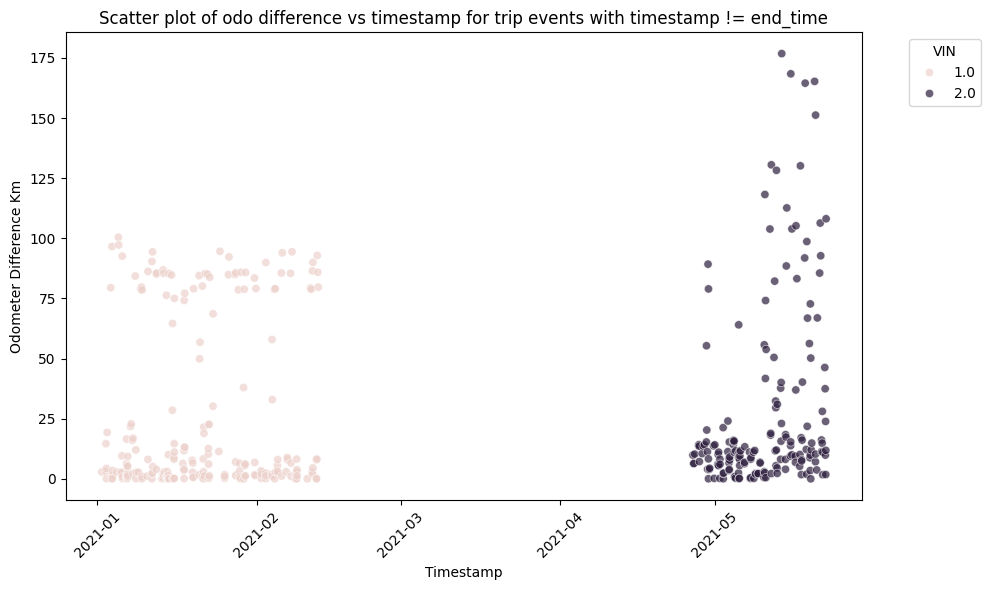

In [238]:

filtered_data = data[(data['event'] == 'trip') & (data['timestamp'] != data['end_time'])].copy()


filtered_data['odo_diff'] = filtered_data['end_odo'] - filtered_data['odo']

# plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=filtered_data, 
    x='timestamp', 
    y='odo_diff', 
    hue='vin', 
    alpha=0.7
)
plt.title('Scatter plot of odo difference vs timestamp for trip events with timestamp != end_time')
plt.xlabel('Timestamp')
plt.ylabel('Odometer Difference Km')
plt.xticks(rotation=45)
plt.legend(title='VIN', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Detect Anomalous Trip Events with SoC Increase

In [239]:
anomalous_rows_trip = data[(data['event'] == 'trip') & (data['end_soc'] > data['soc']) ]
print(f"Number of anamalous rows: {anomalous_rows_trip.shape[0]}")
anomalous_rows_trip.head(len(anomalous_rows_trip ))

Number of anamalous rows: 6


vin           timestamp            end_time           odo       end_odo  \
21   1.0 2021-01-05 17:05:00 2021-01-05 17:12:00   4868.421875   4870.953125   
68   2.0 2021-05-02 16:53:00 2021-05-02 16:57:00   2609.656250   2611.796875   
88   2.0 2021-05-04 22:08:00 2021-05-04 22:12:00   2777.484375   2778.328125   
207  1.0 2021-01-08 11:13:00 2021-01-08 13:23:00   5201.687500   5201.765625   
236  1.0 2021-01-13 19:30:00 2021-01-13 20:46:00   5996.968750   5998.875000   
432  1.0 2021-02-12 13:53:00 2021-02-12 22:27:00  10063.062500  10063.093750   

      soc  end_soc event charge_mode  duration  avg_speed  
21   58.4     58.8  trip           0       7.0  21.696429  
68   33.3     33.7  trip           0       4.0  32.109375  
88   24.3     24.7  trip           0       4.0  12.656250  
207  40.0     40.3  trip           0     130.0   0.036058  
236  50.1     50.9  trip           0      76.0   1.504934  
432  78.8     79.2  trip           0     514.0   0.003648

Minimum Diff SoC:  -0.7999999999999972


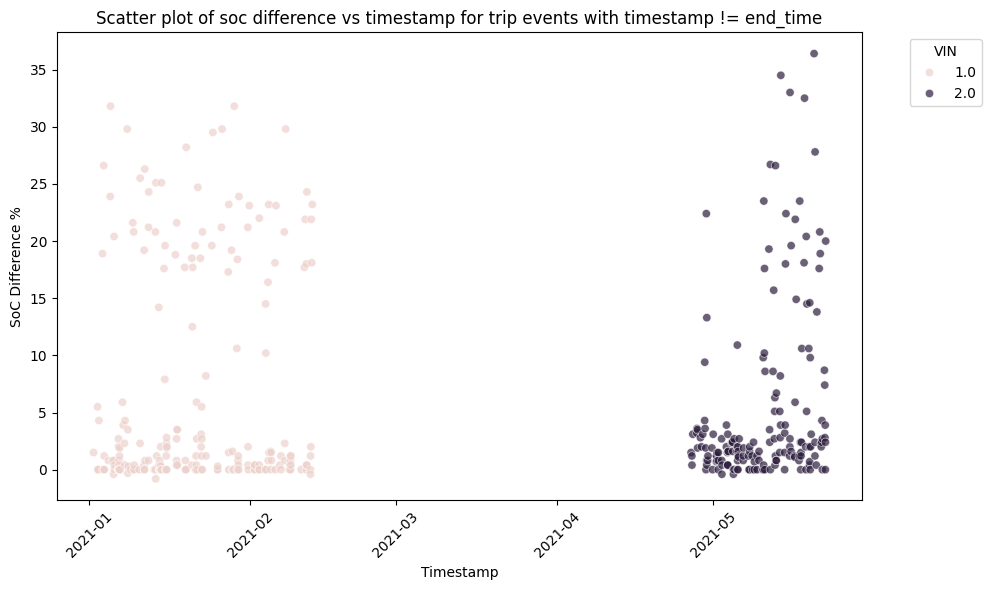

In [240]:

filtered_data = data[(data['event'] == 'trip') & (data['timestamp'] != data['end_time'])].copy()
filtered_data['soc_diff'] = filtered_data['soc'] - filtered_data['end_soc']

print("Minimum Diff SoC: ",filtered_data['soc_diff'].min())
# plot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=filtered_data, 
    x='timestamp', 
    y='soc_diff', 
    hue='vin', 
    alpha=0.7
)
plt.title('Scatter plot of soc difference vs timestamp for trip events with timestamp != end_time')
plt.xlabel('Timestamp')
plt.ylabel('SoC Difference %')
plt.xticks(rotation=45)
plt.legend(title='VIN', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Removed if it doesn't respect the bound 

In [241]:
#if it increase more than 1% delete the row from data 
inital_length = len(data)
data = data[~((data['event'] == 'trip') & ((data['end_soc'] - data['soc']) > 1))].reset_index(drop=True)
final_length = len(data)
print(f"Number of rows removed: {inital_length - final_length}")


Number of rows removed: 0


### Detecting and removing Anomalous Trip Events with Odo Decrease

In [242]:
anomalous_rows_trip = data[(data['event'] == 'trip') & (data['end_odo'] < data['odo']) ]
print(f"Number of anamalous rows: {anomalous_rows_trip.shape[0]}")
anomalous_rows_trip.head(len(anomalous_rows_trip ))


Number of anamalous rows: 0


Empty DataFrame
Columns: [vin, timestamp, end_time, odo, end_odo, soc, end_soc, event, charge_mode, duration, avg_speed]
Index: []

In [243]:
data = data[~((data['event'] == 'trip') & (data['end_odo'] < data['odo']))].reset_index(drop=True)

### Identify Charge Events with No Charge Despite Time Elapsed

In [244]:
useless_rows_charge = data[(data['event'] == 'charge') & (data['soc'] == data['end_soc'])& (data['timestamp'] != data['end_time'])]
print(f"Number of useless rows: {useless_rows_charge.shape[0]}")
useless_rows_charge.head(len(useless_rows_charge))

Number of useless rows: 9


vin           timestamp            end_time          odo      end_odo  \
19   1.0 2021-01-05 11:57:00 2021-01-05 11:59:00  4868.421875  4868.421875   
131  2.0 2021-05-10 17:54:00 2021-05-10 18:29:00  3083.781250  3083.781250   
157  2.0 2021-05-13 00:13:00 2021-05-13 00:21:00  3869.421875  3869.421875   
265  1.0 2021-01-15 20:04:00 2021-01-15 21:09:00  6454.234375  6454.234375   
426  1.0 2021-02-12 14:30:00 2021-02-12 15:44:00  9793.375000  9793.375000   
483  2.0 2021-05-19 14:25:00 2021-05-19 14:29:00  5928.312500  5928.312500   
487  2.0 2021-05-19 18:16:00 2021-05-19 18:33:00  6051.250000  6051.250000   
511  2.0 2021-05-21 22:17:00 2021-05-21 22:35:00  6816.406250  6816.406250   
518  2.0 2021-05-22 11:27:00 2021-05-22 11:38:00  6903.546875  6903.546875   

      soc  end_soc   event charge_mode  duration  avg_speed  
19   16.0     16.0  charge         240       2.0        0.0  
131  76.0     76.0  charge         120      35.0        0.0  
157  30.1     30.1  charge         120       8.0        0.0  
265  51.3     51.3  charge         240      65.0        0.0  
426  98.8     98.8  charge         240      74.0        0.0  
483  79.6     79.6  charge         240       4.0        0.0  
487  54.9     54.9  charge         120      17.0        0.0  
511  36.0     36.0  charge           0      18.0        0.0  
518  75.6     75.6  charge         120      11.0        0.0

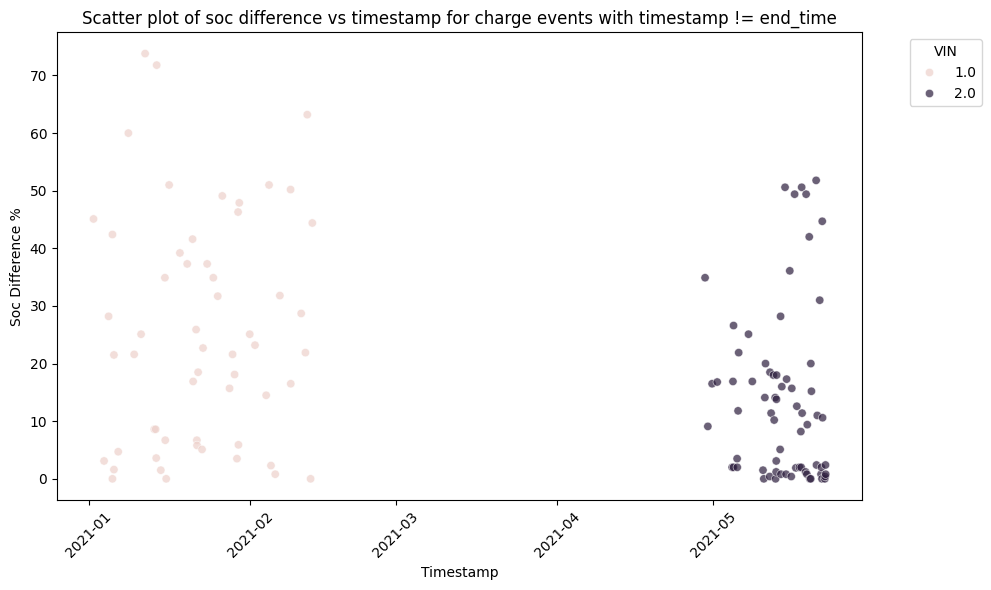

In [245]:

filtered_data = data[(data['event'] == 'charge') & (data['timestamp'] != data['end_time'])].copy()


filtered_data['soc_diff'] = filtered_data['end_soc'] - filtered_data['soc']


plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=filtered_data, 
    x='timestamp', 
    y='soc_diff', 
    hue='vin', 
    alpha=0.7
)
plt.title('Scatter plot of soc difference vs timestamp for charge events with timestamp != end_time')
plt.xlabel('Timestamp')
plt.ylabel('Soc Difference %')
plt.xticks(rotation=45)
plt.legend(title='VIN', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Cleaning

In [246]:
length_before = len(data)
data = data[~((data['event'] == 'charge') & 
              (data['soc'] == data['end_soc']) & 
              (data['timestamp'] != data['end_time']))].reset_index(drop=True)
length_after = len(data)
print(f"Number of rows removed: {length_before - length_after}")


Number of rows removed: 9


### Detecting and removing Anomalous Charge Events with SoC Decrease

In [247]:
anomalows_rows_charge = data[(data['event'] == 'charge') & (data['end_soc'] < data['soc']) ]
print(f"Number of anamalous rows: {anomalows_rows_charge.shape[0]}")
anomalows_rows_charge.head(len(anomalows_rows_charge))
data = data[~((data['event'] == 'charge') & (data['end_soc'] < data['soc']))].reset_index(drop=True)

Number of anamalous rows: 0


### Anomalies in Speed

In [248]:
speed_trip = data[data['event'] == 'trip']
print("📊 Statistics on driven km:\n", speed_trip['avg_speed'].describe())
p99_speed = speed_trip['avg_speed'].quantile(0.99)
print(f"99th percentile of average speed: {p99_speed:.2f} km/h")


📊 Statistics on driven km:
 count    402.000000
mean      35.035433
std       39.967470
min        0.000000
25%       17.658306
50%       30.941201
75%       44.227371
max      672.991071
Name: avg_speed, dtype: float64
99th percentile of average speed: 98.57 km/h


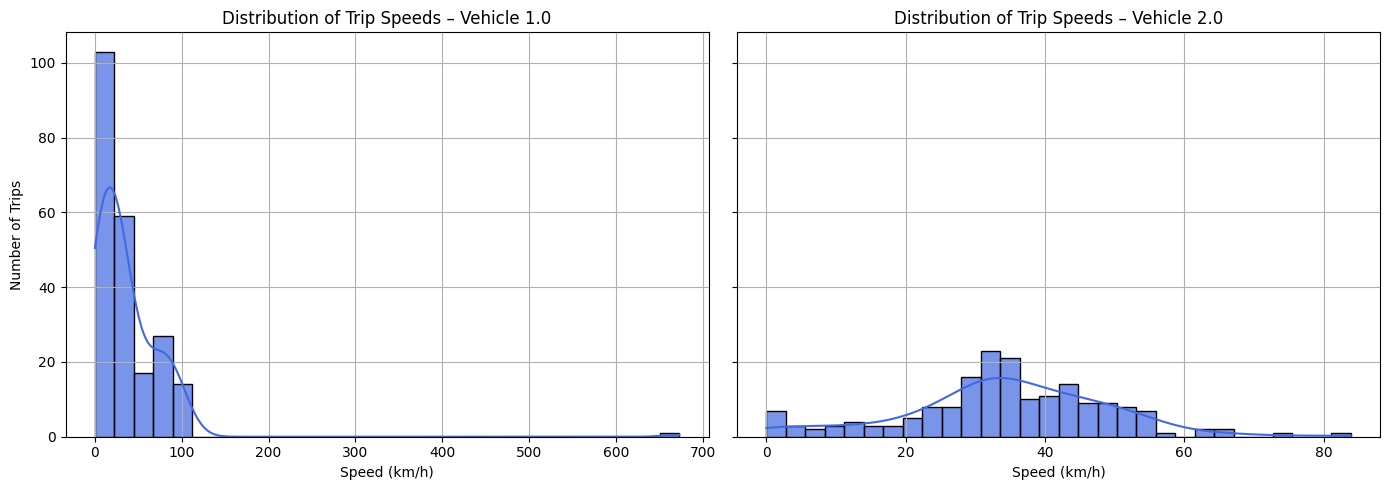

In [249]:
vehicles = speed_trip['vin'].dropna().unique()[:2]  
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for i, vin in enumerate(vehicles):
    subset = speed_trip[speed_trip['vin'] == vin]

    sns.histplot(
        data=subset,
        x='avg_speed',
        bins=30,
        kde=True,
        color='royalblue',
        edgecolor='black',
        alpha=0.7,
        ax=axes[i]
    )
    axes[i].set_title(f'Distribution of Trip Speeds – Vehicle {vin}')
    axes[i].set_xlabel('Speed (km/h)')
    axes[i].set_ylabel('Number of Trips')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [250]:
max_speed = data['avg_speed'].max()
max_speed_row = data[data['avg_speed'] == max_speed]

print("\n Row with maximum speed:")
print(max_speed_row)

data = data.drop(max_speed_row.index).reset_index(drop=True)


 Row with maximum speed:
     vin           timestamp            end_time       odo      end_odo   soc  \
212  1.0 2021-01-09 16:09:00 2021-01-09 16:16:00  5366.875  5445.390625  56.8   

     end_soc event charge_mode  duration   avg_speed  
212     56.4  trip           0       7.0  672.991071  


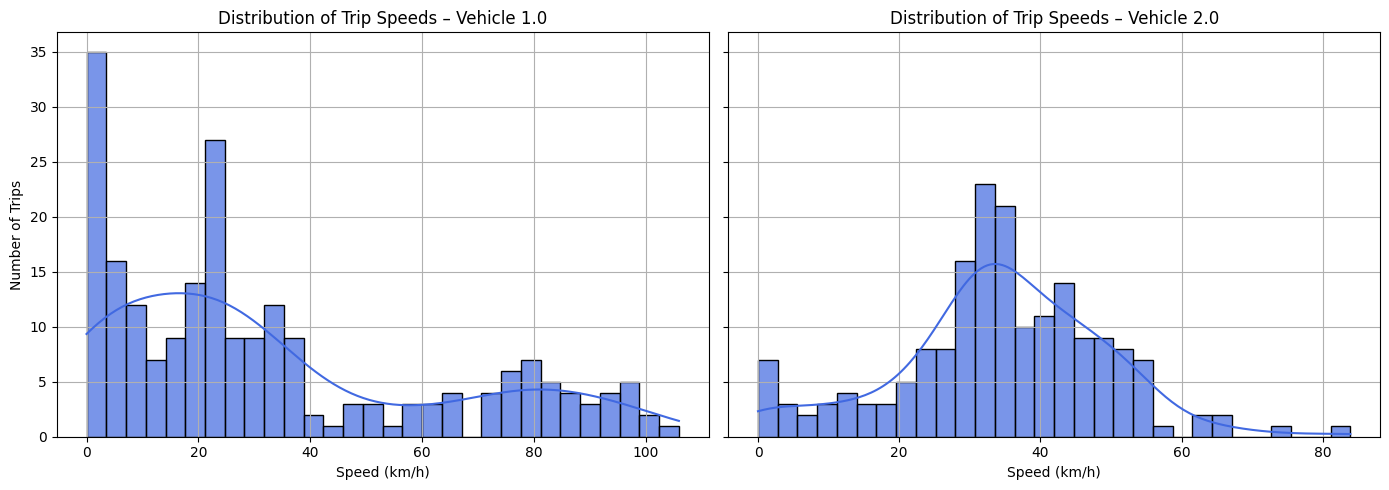

In [251]:
speed_trip = data[data['event'] == 'trip']
vehicles = speed_trip['vin'].dropna().unique()[:2]  
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for i, vin in enumerate(vehicles):
    subset = speed_trip[speed_trip['vin'] == vin]

    sns.histplot(
        data=subset,
        x='avg_speed',
        bins=30,
        kde=True,
        color='royalblue',
        edgecolor='black',
        alpha=0.7,
        ax=axes[i]
    )
    axes[i].set_title(f'Distribution of Trip Speeds – Vehicle {vin}')
    axes[i].set_xlabel('Speed (km/h)')
    axes[i].set_ylabel('Number of Trips')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

## Discharge Analysis

In [252]:

trip_data = data[data['event'] == 'trip'].copy().reset_index(drop=True)
trip_data['km_driven'] = trip_data['end_odo'] - trip_data['odo']
trip_data['discharge'] = trip_data['soc'] - trip_data['end_soc']
print("📊 Statistics on driven km:\n", trip_data['km_driven'].describe())
print("\n🔋 Statistics on discharge:\n", trip_data['discharge'].describe())
print(trip_data['discharge'])

📊 Statistics on driven km:
 count    401.000000
mean      26.251052
std       36.826097
min        0.000000
25%        2.062500
50%        8.265625
75%       32.921875
max      176.796875
Name: km_driven, dtype: float64

🔋 Statistics on discharge:
 count    401.000000
mean       5.893017
std        8.803871
min       -0.800000
25%        0.000000
50%        1.500000
75%        7.400000
max       36.400000
Name: discharge, dtype: float64
0       1.5
1       0.0
2       5.5
3       0.0
4       0.0
       ... 
396     2.8
397     3.9
398     0.0
399     2.4
400    20.0
Name: discharge, Length: 401, dtype: float64


### Trip Efficiency Analysis: Battery Consumption per Distance and Distance per Battery Unit 

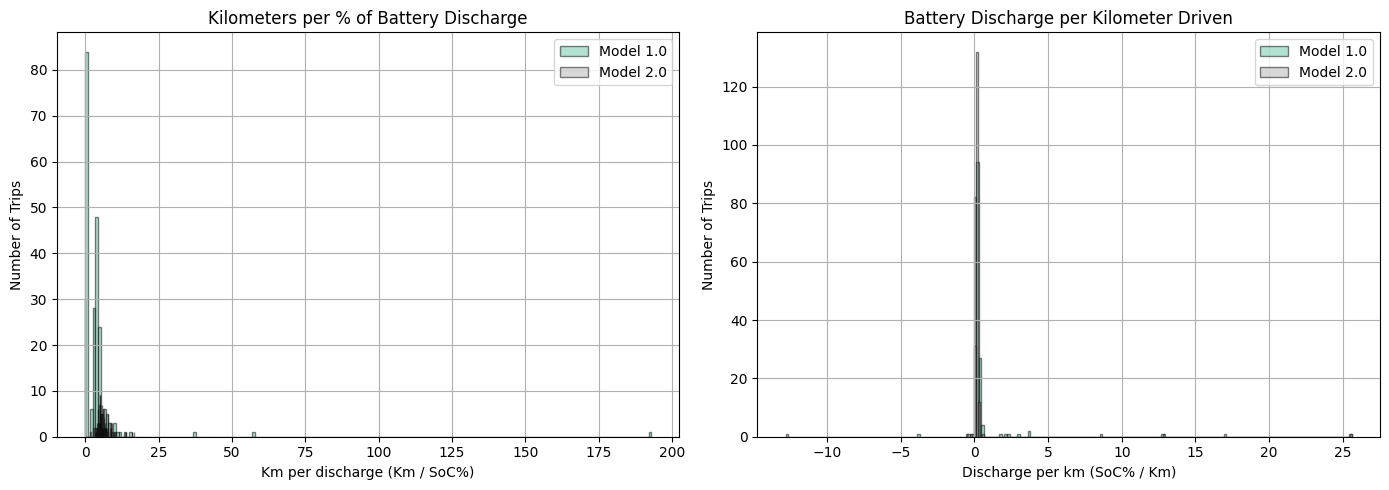

In [253]:

trip_data['km_per_perc_of_battery'] = trip_data.apply(
    lambda row: row['km_driven'] / row['discharge'] if row['discharge'] > 0 else 0,
    axis=1
)

trip_data['discharge_per_km'] = trip_data.apply(
    lambda row: row['discharge'] / row['km_driven'] if row['km_driven'] > 0 else 0,
    axis=1
)

# Setup
models = trip_data['vin'].dropna().unique()
colors = plt.get_cmap('Set2', len(models))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))


for i, model in enumerate(models):
    subset = trip_data[trip_data['vin'] == model]
    axes[0].hist(
        subset['km_per_perc_of_battery'],
        bins=len(subset),
        alpha=0.5,
        color=colors(i),
        label=f'Model {model}',
        edgecolor='black'
    )

axes[0].set_title('Kilometers per % of Battery Discharge')
axes[0].set_xlabel('Km per discharge (Km / SoC%)')
axes[0].set_ylabel('Number of Trips')
axes[0].grid(True)
axes[0].legend()

for i, model in enumerate(models):
    subset = trip_data[trip_data['vin'] == model]
    axes[1].hist(
        subset['discharge_per_km'],
        bins=len(subset),
        alpha=0.5,
        color=colors(i),
        label=f'Model {model}',
        edgecolor='black'
    )

axes[1].set_title('Battery Discharge per Kilometer Driven')
axes[1].set_xlabel('Discharge per km (SoC% / Km)')
axes[1].set_ylabel('Number of Trips')
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()

In [254]:
max_km = trip_data['km_driven'].max()
max_km_row = trip_data[trip_data['km_driven'] == max_km]

print("\n Row with maximum speed:")
print(max_km_row)


 Row with maximum speed:
     vin           timestamp            end_time          odo     end_odo  \
136  2.0 2021-05-14 00:58:00 2021-05-14 04:54:00  4160.046875  4336.84375   

      soc  end_soc event charge_mode  duration  avg_speed   km_driven  \
136  43.9      9.4  trip           0     236.0  44.948358  176.796875   

     discharge  km_per_perc_of_battery  discharge_per_km  
136       34.5                5.124547          0.195139  


### Analysis in Driven Km and SoC Discharge

#### Distribution of Trip Distance and Battery Discharge per Vehicle

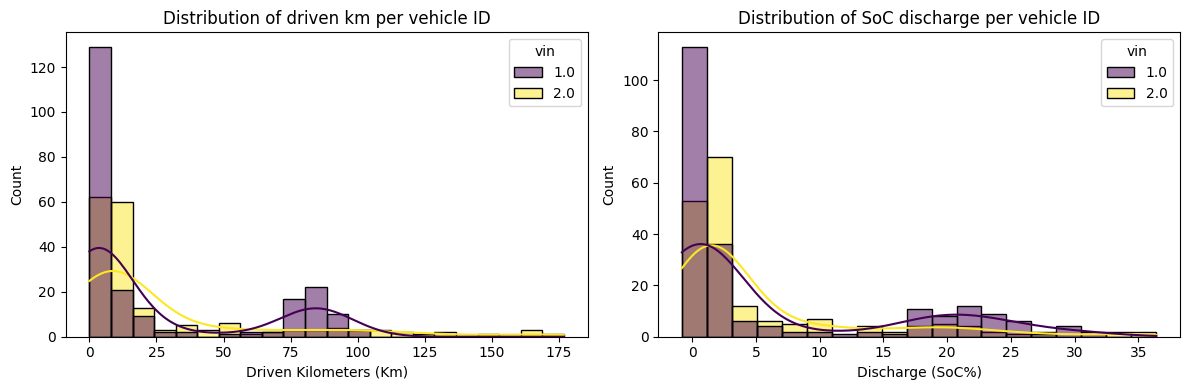

In [255]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(data=trip_data, x='km_driven', kde=True, hue='vin', palette='viridis', ax=axes[0])
axes[0].set_title('Distribution of driven km per vehicle ID')
axes[0].set_xlabel('Driven Kilometers (Km)')

sns.histplot(data=trip_data, x='discharge', kde=True, hue='vin', palette='viridis', ax=axes[1])
axes[1].set_title('Distribution of SoC discharge per vehicle ID')
axes[1].set_xlabel('Discharge (SoC%)')

plt.tight_layout()
plt.show()

#### 3D Density Surface of Kilometers Driven vs SoC Discharge per Vehicle

In [256]:

vehicles = trip_data['vin'].unique()
colors = ['Blues', 'Reds', 'Greens', 'Purples', 'Oranges', 'Viridis'] 

fig = go.Figure()

x = trip_data['km_driven'].values
y = trip_data['discharge'].values
xedges = np.linspace(x.min(), x.max(), 31)
yedges = np.linspace(y.min(), y.max(), 31)
xcenters = 0.5 * (xedges[:-1] + xedges[1:])
ycenters = 0.5 * (yedges[:-1] + yedges[1:])
X, Y = np.meshgrid(xcenters, ycenters, indexing="ij")

for i, vin in enumerate(vehicles):
    subset = trip_data[trip_data['vin'] == vin]
    hist, _, _ = np.histogram2d(
        subset['km_driven'], subset['discharge'],
        bins=[xedges, yedges],
        density=True
    )
    
    # Surface plot
    fig.add_trace(go.Surface(
        x=X,
        y=Y,
        z=hist,
        colorscale=colors[i % len(colors)],
        showscale=False,
        name=f'Vehicle {vin}',
        opacity=0.8,
        hoverinfo="skip", 
        legendgroup=f'{vin}', 
        showlegend=True  
    ))

    

fig.update_layout(
    title='3D Histogram Surface of driven km and discharge by each Vehicle',
    scene=dict(
        xaxis_title='Driven Kilometers',
        yaxis_title='Discharge (SoC%)',
        zaxis_title='Density'
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(title="Vehicles")
)

fig.show()

In [257]:


vehicles = trip_data['vin'].unique()
colors = ['Viridis', 'Cividis', 'Plasma', 'Inferno', 'Magma', 'Turbo']


cols = 2
rows = int(np.ceil(len(vehicles) / cols))

fig = make_subplots(
    rows=rows, 
    cols=cols, 
    specs=[[{'type': 'surface'}]*cols for _ in range(rows)],
    subplot_titles=[f'Vehicle {vin}' for vin in vehicles]
)

x = trip_data['km_driven'].values
y = trip_data['discharge'].values
xgrid = np.linspace(x.min(), x.max(), 100)
ygrid = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(xgrid, ygrid)
positions = np.vstack([X.ravel(), Y.ravel()])

for idx, vin in enumerate(vehicles):
    subset = trip_data[trip_data['vin'] == vin]
    xy_subset = np.vstack([subset['km_driven'].values, subset['discharge'].values])
    kde = gaussian_kde(xy_subset)
    Z = np.reshape(kde(positions).T, X.shape)

    row = idx // cols + 1
    col = idx % cols + 1

    fig.add_trace(
        go.Surface(
            x=X,
            y=Y,
            z=Z,
            colorscale=colors[idx % len(colors)],
            showscale=False,
            opacity=0.8
        ),
        row=row, 
        col=col
    )

fig.update_layout(
    title='3D KDE Surface of driven Km and discharge by Vehicle',
    height=400 * rows,
    width=700 * cols,
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

#### 3D Histogram of Driven Kilometers and Battery Discharge

/Users/gabriele/Desktop/Magistrale/Tesi/env/lib/python3.13/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning:

divide by zero encountered in matmul

/Users/gabriele/Desktop/Magistrale/Tesi/env/lib/python3.13/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning:

overflow encountered in matmul



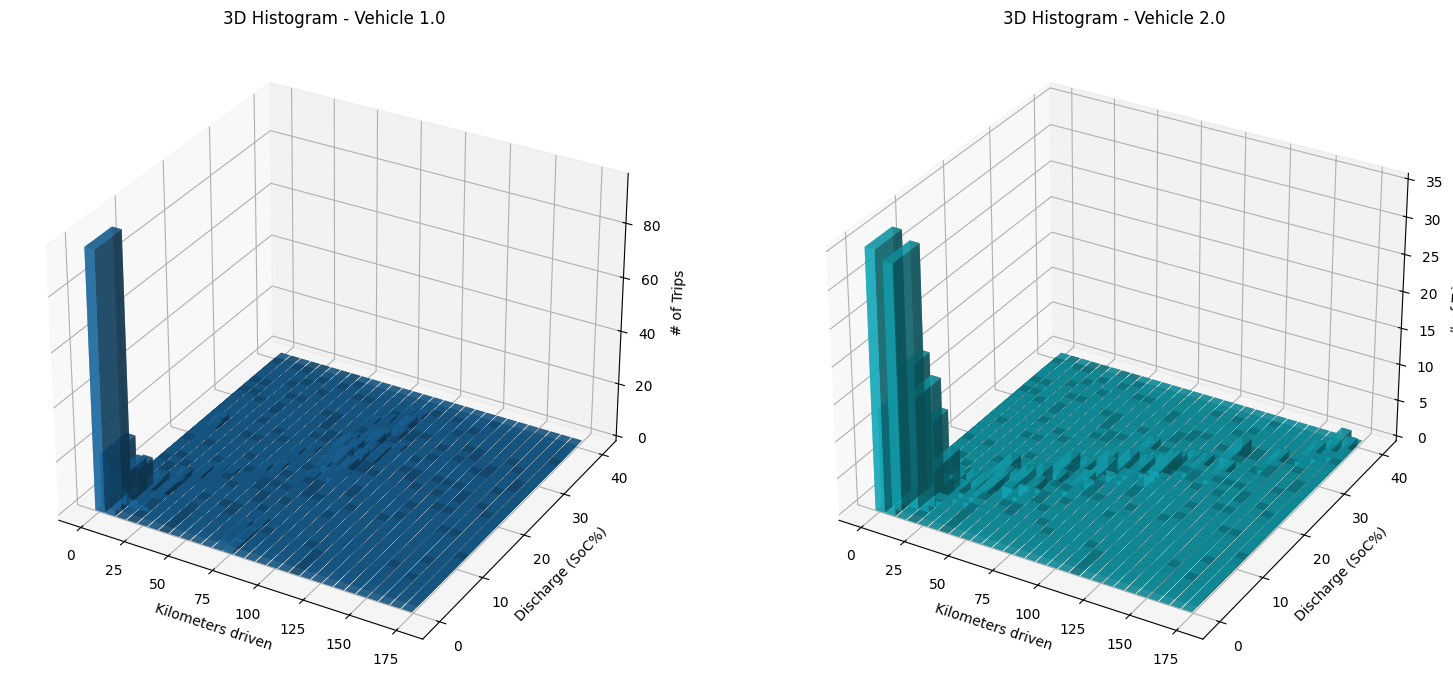

In [258]:

vehicles = trip_data['vin'].unique()[:2]  
colors = plt.get_cmap('tab10', len(vehicles))

fig, axes = plt.subplots(1, 2, figsize=(16, 7), subplot_kw={'projection': '3d'})  # 1 riga, 2 colonne

xedges = np.linspace(trip_data['km_driven'].min(), trip_data['km_driven'].max(), 30)
yedges = np.linspace(trip_data['discharge'].min(), trip_data['discharge'].max(), 30)
dx = dy = (xedges[1] - xedges[0]) * 0.9

for idx, (ax, vin) in enumerate(zip(axes, vehicles)):
    subset = trip_data[trip_data['vin'] == vin]
    hist, _, _ = np.histogram2d(subset['km_driven'], subset['discharge'], bins=[xedges, yedges], density=False)

    xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
    xpos = xpos.ravel()
    ypos = ypos.ravel()
    zpos = np.zeros_like(xpos)
    dz = hist.ravel()

    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=colors(idx), alpha=0.7, shade=True)
    ax.set_title(f'3D Histogram - Vehicle {vin}')
    ax.set_xlabel('Kilometers driven')
    ax.set_ylabel('Discharge (SoC%)')
    ax.set_zlabel('# of Trips')

plt.tight_layout()
plt.show()

#### Scatter Plot of Battery Discharge vs Kilometers Driven by Vehicle

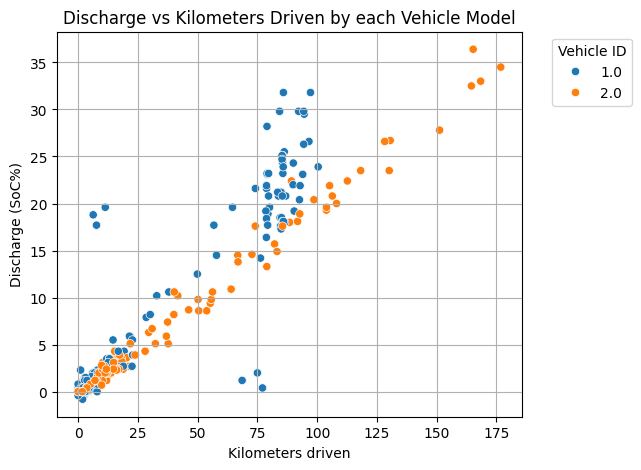

In [259]:
plt.figure(figsize=(6, 5))
sns.scatterplot(data=trip_data, x='km_driven', y='discharge',hue = 'vin', palette = 'tab10')
plt.title('Discharge vs Kilometers Driven by each Vehicle Model')
plt.legend(title='Vehicle ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Kilometers driven')
plt.ylabel('Discharge (SoC%)')
plt.grid(True)
plt.show()


trip_data = trip_data.reset_index() 

fig = px.scatter(
    trip_data,
    x='km_driven',
    y='discharge',
    color='vin',
    hover_data=['index'], 
    title='Discharge vs Kilometers Driven by each Vehicle Model',
    labels={
        'km_driven': 'Kilometers Driven',
        'discharge': 'Discharge (SoC%)',
        'vin': 'Vehicle ID'
    }
)

fig.update_layout(
    legend_title_text='Vehicle ID',
    margin=dict(l=20, r=20, t=60, b=20),
    hovermode='closest'
)

fig.show()

In [260]:
# Mahalanobis distance for anomaly detection
xy = trip_data[['km_driven', 'discharge']].to_numpy()
cov = np.cov(xy, rowvar=False)
inv_cov = np.linalg.inv(cov)
mean = xy.mean(axis=0)

dists = np.array([ (x-mean).T @ inv_cov @ (x-mean) for x in xy ])
trip_data['mah_dist'] = dists
threshold = stats.chi2.ppf(0.99, df=2)  # 99° perc.
anomalies = trip_data[dists > threshold]
print(f"Number of anomalies detected: {len(anomalies)}")
print("\nAnomalies detected:")
anomalies.head(len(anomalies))

Number of anomalies detected: 19

Anomalies detected:


index  vin           timestamp            end_time          odo  \
14      14  1.0 2021-01-05 03:00:00 2021-01-05 04:01:00  4768.390625   
136    136  2.0 2021-05-14 00:58:00 2021-05-14 04:54:00  4160.046875   
162    162  1.0 2021-01-08 08:04:00 2021-01-08 08:57:00  5105.359375   
214    214  1.0 2021-01-15 23:00:00 2021-01-16 09:39:00  6488.343750   
215    215  1.0 2021-01-17 14:20:00 2021-01-17 15:14:00  6563.365008   
223    223  1.0 2021-01-17 23:12:00 2021-01-18 11:19:00  6689.750000   
224    224  1.0 2021-01-19 09:46:00 2021-01-19 10:59:00  6766.881646   
229    229  1.0 2021-01-19 16:27:00 2021-01-19 17:29:00  6785.125000   
253    253  1.0 2021-01-23 11:41:00 2021-01-23 17:03:00  7551.140625   
254    254  1.0 2021-01-24 14:29:00 2021-01-24 15:23:00  7619.759321   
255    255  1.0 2021-01-24 19:28:00 2021-01-24 20:56:00  7631.140625   
260    260  1.0 2021-01-26 13:39:00 2021-01-26 14:52:00  7813.734375   
272    272  1.0 2021-01-28 22:05:00 2021-01-28 22:56:00  8176.765625   
318    318  1.0 2021-02-07 19:40:00 2021-02-07 21:00:00  9327.125000   
345    345  2.0 2021-05-15 19:24:00 2021-05-16 00:11:00  4624.343750   
356    356  2.0 2021-05-17 16:10:00 2021-05-17 19:51:00  5171.656250   
364    364  2.0 2021-05-18 14:24:00 2021-05-18 18:16:00  5484.109375   
379    379  2.0 2021-05-20 10:29:00 2021-05-20 14:14:00  6078.125000   
382    382  2.0 2021-05-20 15:07:00 2021-05-20 19:20:00  6260.734375   

         end_odo   soc  end_soc event charge_mode  duration   avg_speed  \
14   4865.609375  48.2     16.4  trip           0      61.0   95.625000   
136  4336.843750  43.9      9.4  trip           0     236.0   44.948358   
162  5189.656250  74.1     44.3  trip           0      53.0   95.430425   
214  6563.365008  43.5     41.5  trip           0     639.0    7.044250   
215  6569.703125  92.5     73.7  trip           0      54.0    7.042352   
223  6766.881646  39.2     38.8  trip           0     727.0    6.365748   
224  6774.593750  78.0     60.3  trip           0      73.0    6.338716   
229  6864.156250  58.0     29.8  trip           0      62.0   76.481855   
253  7619.759321  42.7     41.5  trip           0     322.0   12.786092   
254  7631.140625  78.8     59.2  trip           0      54.0   12.645893   
255  7725.734375  60.0     30.5  trip           0      88.0   64.495739   
260  7905.984375  75.2     45.4  trip           0      73.0   75.821918   
272  8262.656250  67.8     36.0  trip           0      51.0  101.047794   
318  9421.515625  38.4      8.6  trip           0      80.0   70.792969   
345  4792.734375  74.9     41.9  trip           0     287.0   35.203615   
356  5301.796875  52.9     29.4  trip           0     221.0   35.332296   
364  5648.609375  65.4     32.9  trip           0     232.0   42.543103   
379  6243.375000  85.0     48.6  trip           0     225.0   44.066667   
382  6411.953125  45.0     17.2  trip           0     253.0   35.862154   

      km_driven  discharge  km_per_perc_of_battery  discharge_per_km  \
14    97.218750       31.8                3.057193          0.327097   
136  176.796875       34.5                5.124547          0.195139   
162   84.296875       29.8                2.828754          0.353513   
214   75.021258        2.0               37.510629          0.026659   
215    6.338117       18.8                0.337134          2.966181   
223   77.131646        0.4              192.829115          0.005186   
224    7.712104       17.7                0.435712          2.295094   
229   79.031250       28.2                2.802527          0.356821   
253   68.618696        1.2               57.182247          0.017488   
254   11.381304       19.6                0.580679          1.722123   
255   94.593750       29.5                3.206568          0.311860   
260   92.250000       29.8                3.095638          0.323035   
272   85.890625       31.8                2.700963          0.370238   
318   94.390625       29.8                3.167471     

In [261]:
# Isolation Forest for anomaly detection
clf = IsolationForest(contamination=0.05, random_state=42)
trip_data['anomaly_if'] = clf.fit_predict(trip_data[['km_driven', 'discharge']])
anomalies = trip_data[trip_data['anomaly_if'] == -1]
print(f"Number of anomalies detected with Isolation Forest: {len(anomalies)}")
print("\nAnomalies detected with Isolation Forest:")
anomalies.head(len(anomalies))

Number of anomalies detected with Isolation Forest: 20

Anomalies detected with Isolation Forest:


index  vin           timestamp            end_time          odo  \
14      14  1.0 2021-01-05 03:00:00 2021-01-05 04:01:00  4768.390625   
80      80  2.0 2021-05-05 16:13:00 2021-05-05 17:40:00  2811.671875   
109    109  2.0 2021-05-10 18:29:00 2021-05-10 20:42:00  3083.781250   
118    118  2.0 2021-05-12 00:37:00 2021-05-12 03:30:00  3515.250000   
126    126  2.0 2021-05-13 00:21:00 2021-05-13 02:48:00  3869.421875   
136    136  2.0 2021-05-14 00:58:00 2021-05-14 04:54:00  4160.046875   
162    162  1.0 2021-01-08 08:04:00 2021-01-08 08:57:00  5105.359375   
214    214  1.0 2021-01-15 23:00:00 2021-01-16 09:39:00  6488.343750   
215    215  1.0 2021-01-17 14:20:00 2021-01-17 15:14:00  6563.365008   
223    223  1.0 2021-01-17 23:12:00 2021-01-18 11:19:00  6689.750000   
224    224  1.0 2021-01-19 09:46:00 2021-01-19 10:59:00  6766.881646   
232    232  1.0 2021-01-20 20:39:00 2021-01-20 21:50:00  6950.296875   
253    253  1.0 2021-01-23 11:41:00 2021-01-23 17:03:00  7551.140625   
254    254  1.0 2021-01-24 14:29:00 2021-01-24 15:23:00  7619.759321   
272    272  1.0 2021-01-28 22:05:00 2021-01-28 22:56:00  8176.765625   
345    345  2.0 2021-05-15 19:24:00 2021-05-16 00:11:00  4624.343750   
356    356  2.0 2021-05-17 16:10:00 2021-05-17 19:51:00  5171.656250   
364    364  2.0 2021-05-18 14:24:00 2021-05-18 18:16:00  5484.109375   
379    379  2.0 2021-05-20 10:29:00 2021-05-20 14:14:00  6078.125000   
382    382  2.0 2021-05-20 15:07:00 2021-05-20 19:20:00  6260.734375   

         end_odo   soc  end_soc event charge_mode  duration   avg_speed  \
14   4865.609375  48.2     16.4  trip           0      61.0   95.625000   
80   2875.703125  50.5     39.6  trip           0      87.0   44.159483   
109  3202.000000  76.0     52.5  trip           0     133.0   53.331767   
118  3645.812500  43.5     16.8  trip           0     173.0   45.281792   
126  3997.687500  30.1      3.5  trip           0     147.0   52.353316   
136  4336.843750  43.9      9.4  trip           0     236.0   44.948358   
162  5189.656250  74.1     44.3  trip           0      53.0   95.430425   
214  6563.365008  43.5     41.5  trip           0     639.0    7.044250   
215  6569.703125  92.5     73.7  trip           0      54.0    7.042352   
223  6766.881646  39.2     38.8  trip           0     727.0    6.365748   
224  6774.593750  78.0     60.3  trip           0      73.0    6.338716   
232  7000.187500  50.5     38.0  trip           0      71.0   42.161092   
253  7619.759321  42.7     41.5  trip           0     322.0   12.786092   
254  7631.140625  78.8     59.2  trip           0      54.0   12.645893   
272  8262.656250  67.8     36.0  trip           0      51.0  101.047794   
345  4792.734375  74.9     41.9  trip           0     287.0   35.203615   
356  5301.796875  52.9     29.4  trip           0     221.0   35.332296   
364  5648.609375  65.4     32.9  trip           0     232.0   42.543103   
379  6243.375000  85.0     48.6  trip           0     225.0   44.066667   
382  6411.953125  45.0     17.2  trip           0     253.0   35.862154   

      km_driven  discharge  km_per_perc_of_battery  discharge_per_km  \
14    97.218750       31.8                3.057193          0.327097   
80    64.031250       10.9                5.874427          0.170229   
109  118.218750       23.5                5.030585          0.198784   
118  130.562500       26.7                4.889981          0.204500   
126  128.265625       26.6                4.822016          0.207382   
136  176.796875       34.5                5.124547          0.195139   
162   84.296875       29.8                2.828754          0.353513   
214   75.021258        2.0               37.510629          0.026659   
215    6.338117       18.8                0.337134          2.966181   
223   77.131646        0.4              192.829115          0.005186   
224    7.712104       17.7                0.435712          2.295094   
232   49.890625       12.5                3.991250  

#### Average speed plot

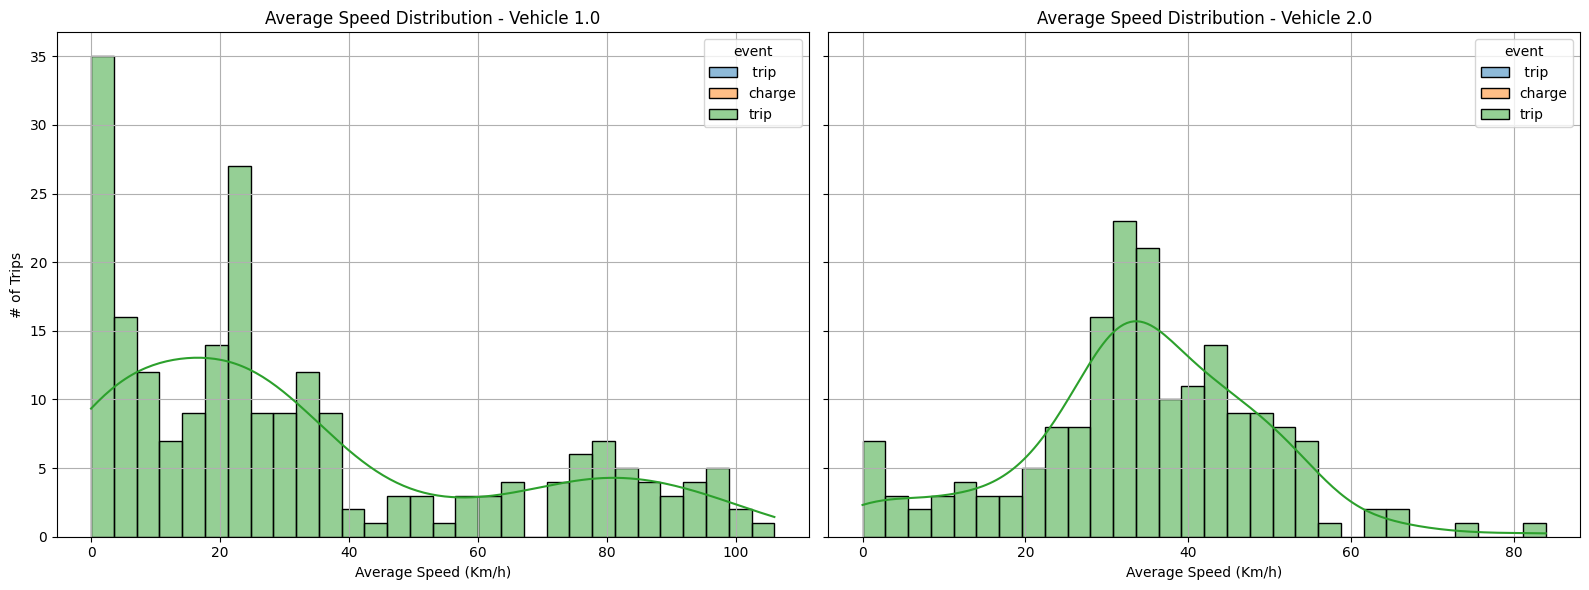

In [262]:
#histogram for average speed
vehicles = trip_data['vin'].dropna().unique()[:2] 
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for ax, vin in zip(axes, vehicles):
    subset = trip_data[trip_data['vin'] == vin]
    sns.histplot(
        data=subset,
        x='avg_speed',
        hue='event',
        multiple='stack',
        kde=True,
        bins=30,
        ax=ax
    )
    ax.set_title(f'Average Speed Distribution - Vehicle {vin}')
    ax.set_xlabel('Average Speed (Km/h)')
    ax.set_ylabel('# of Trips')
    ax.grid(True)
   

plt.tight_layout()
plt.show()


#### Visualize battery discharge across driven distance for each trip

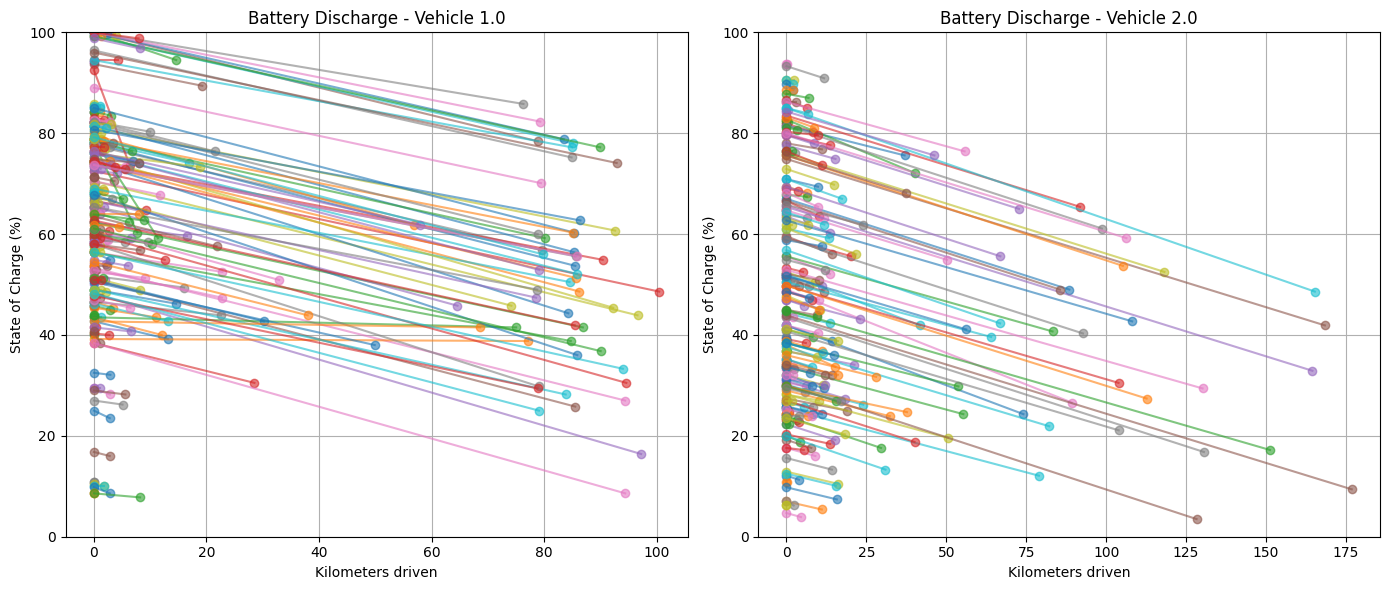

In [263]:


vehicles = trip_data['vin'].unique()[:2]  

fig, axes = plt.subplots(1, 2, figsize=(14, 6))  

for idx, vin in enumerate(vehicles):
    ax = axes[idx]
    subset = trip_data[trip_data['vin'] == vin]

    for _, row in subset.iterrows():
        x_vals = [0, row['km_driven']]
        y_vals = [row['soc'], row['end_soc']]
        ax.plot(x_vals, y_vals, marker='o', alpha=0.6)

    ax.set_title(f'Battery Discharge - Vehicle {vin}')
    ax.set_xlabel('Kilometers driven')
    ax.set_ylabel('State of Charge (%)')
    ax.set_ylim(0, 100)
    ax.grid(True)

plt.tight_layout()
plt.show()

## Charge Analysis

In [264]:
charge_data = data[data['event'] == 'charge'].copy().reset_index(drop=True)
charge_data['diff_battery'] = charge_data['end_soc'] - charge_data['soc']
charge_data['charge_mode'] = charge_data['charge_mode'].cat.remove_unused_categories()
print("🔋 Statistics on charge km:\n", charge_data['diff_battery'].describe())
print("\n🔍 Categories of the 'charge_mode' column:\n"
    f"{charge_data['charge_mode'].cat.categories.tolist()}")


🔋 Statistics on charge km:
 count    116.000000
mean      20.468966
std       18.019494
min        0.400000
25%        4.425000
50%       16.650000
75%       31.725000
max       73.800000
Name: diff_battery, dtype: float64

🔍 Categories of the 'charge_mode' column:
['0', '120', '240', 'DCCharging']


In [265]:
print("\n🔍 Categories of the 'charge_mode' column:\n"
    f"{charge_data['charge_mode'].cat.categories.tolist()}")


🔍 Categories of the 'charge_mode' column:
['0', '120', '240', 'DCCharging']


### Battery Charge Rate per Vehicle: Distribution of %/min by Charge Mode

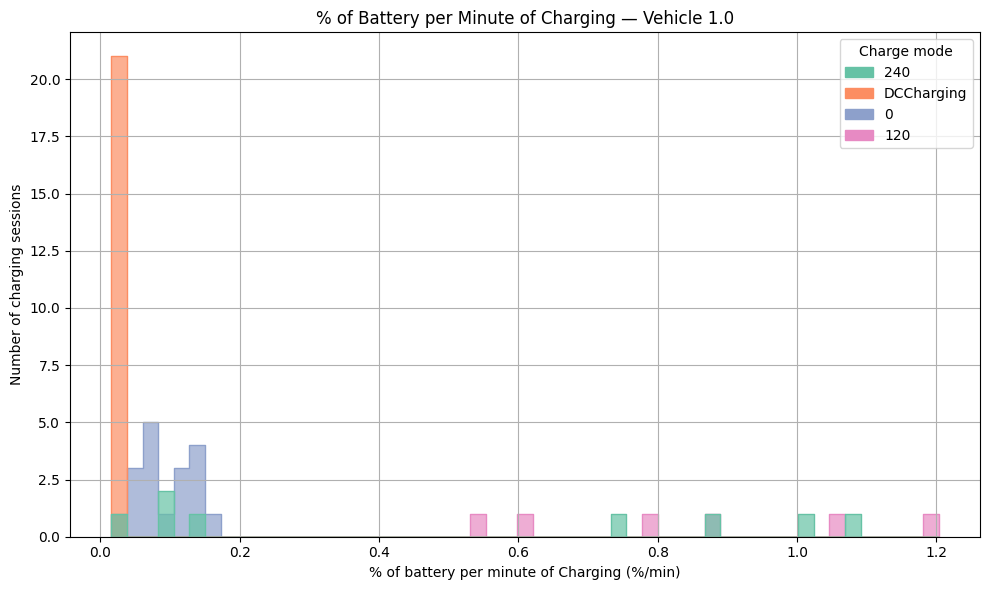

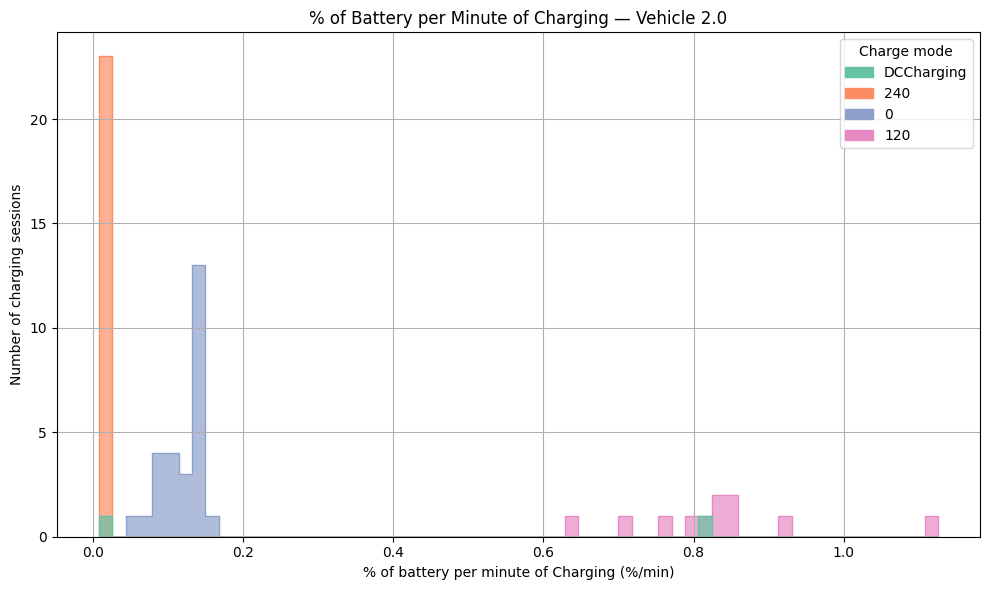

In [266]:
#TODO: Verify this plot


charge_data['perc_per_min'] = charge_data.apply(
    lambda row: row['diff_battery'] / row['duration'] if row['duration'] > 0 else 0,
    axis=1
)

vehicles = charge_data['vin'].dropna().unique()

for vin in vehicles:
    subset = charge_data[charge_data['vin'] == vin]

    if subset.empty:
        continue

    plt.figure(figsize=(10, 6))
    sns.histplot(
        data=subset,
        x='perc_per_min',
        bins=len(subset),
        hue='charge_mode',
        palette='Set2',
        element='step',
        stat='count',
        alpha=0.7
    )
    handles = []
    palette = sns.color_palette('Set2')
    modes = subset['charge_mode'].dropna().unique()

    for i, mode in enumerate(modes):
        color = palette[i % len(palette)]
        patch = mpatches.Patch(color=color, label=mode)
        handles.append(patch)

    plt.title(f'% of Battery per Minute of Charging — Vehicle {vin}')
    plt.xlabel('% of battery per minute of Charging (%/min)')
    plt.ylabel('Number of charging sessions')
    plt.grid(True)
    plt.legend(handles=handles,title='Charge mode')
    plt.tight_layout()
    plt.show()

### Analysis of Vehicle Charging Rates and Density Patterns

#### 3D KDE Surface Plots of Charging Duration vs Battery State Change for Multiple Vehicles

In [267]:
vehicles = charge_data['vin'].dropna().unique()[:2]
color_sets = [
    pc.sequential.Viridis,
    pc.sequential.Plasma,
    pc.sequential.Cividis,
    pc.sequential.Inferno,
    pc.sequential.Magma,
    pc.sequential.Turbo
]

fig = make_subplots(
    rows=1,
    cols=2,
    specs=[[{'type': 'surface'}, {'type': 'surface'}]],
    subplot_titles=[f"Vehicle {vin}" for vin in vehicles]
)

for col, vin in enumerate(vehicles, start=1):
    subset_vehicle = charge_data[charge_data['vin'] == vin]
    modes = subset_vehicle['charge_mode'].dropna().unique()

    x = subset_vehicle['duration'].dropna().values
    y = subset_vehicle['diff_battery'].dropna().values
    xgrid = np.linspace(x.min(), x.max(), 100)
    ygrid = np.linspace(y.min(), y.max(), 100)
    X, Y = np.meshgrid(xgrid, ygrid)
    positions = np.vstack([X.ravel(), Y.ravel()])

    for i, mode in enumerate(modes):
        subset = subset_vehicle[subset_vehicle['charge_mode'] == mode]
        if len(subset) < 2:
            continue
        xy_subset = np.vstack([subset['duration'].values, subset['diff_battery'].values])
        kde = gaussian_kde(xy_subset)
        Z = np.reshape(kde(positions).T, X.shape)

        fig.add_trace(
            go.Surface(
                x=X,
                y=Y,
                z=Z,
                colorscale=color_sets[i % len(color_sets)],
                name=f"{mode} — V{vin}",
                showscale=False,
                opacity=0.8,
                legendgroup=mode,
                showlegend=True,
            ),
            row=1, col=col
        )


fig.update_layout(
    title='3D KDE Surface of Charging Duration vs Battery Difference per Vehicle',
    scene=dict(
        xaxis_title='Duration (min)',
        yaxis_title='Battery difference (SoC%)',
        zaxis_title='Density'
    ),
    scene2=dict(
        xaxis_title='Duration (min)',
        yaxis_title='Battery difference (SoC%)',
        zaxis_title='Density'
    ),
    legend=dict(
        title="Charge Mode",
        itemsizing='constant',
        bgcolor='rgba(255,255,255,0.9)',
        bordercolor='black',
        borderwidth=1,
        x=0.85,
        y=0.95
    ),
    margin=dict(l=0, r=0, b=0, t=40)
)

fig.show()

#### 3D Histogram of Vehicle Charging Patterns by Mode

/Users/gabriele/Desktop/Magistrale/Tesi/env/lib/python3.13/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning:

divide by zero encountered in matmul

/Users/gabriele/Desktop/Magistrale/Tesi/env/lib/python3.13/site-packages/mpl_toolkits/mplot3d/art3d.py:1403: RuntimeWarning:

overflow encountered in matmul



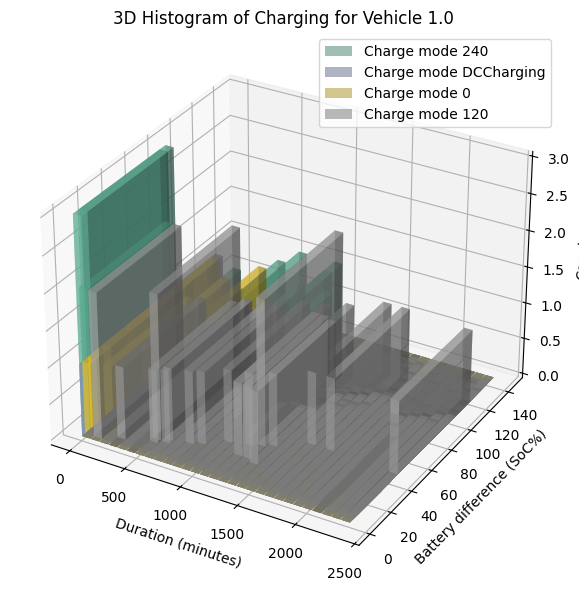

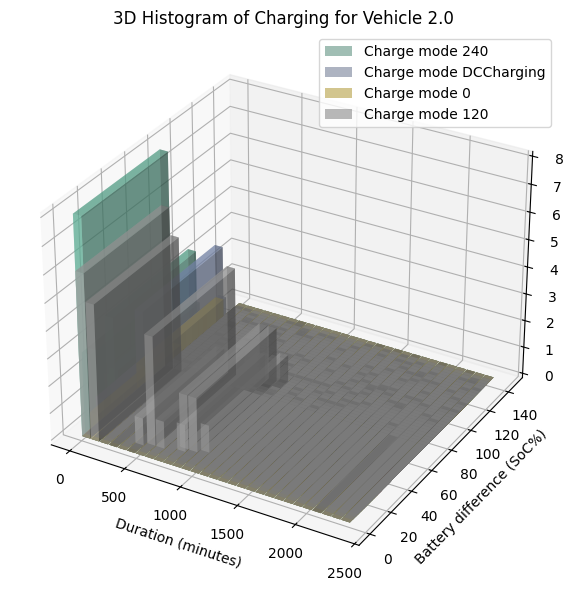

In [268]:
vehicles = charge_data['vin'].dropna().unique()
charge_modes = charge_data['charge_mode'].dropna().unique()
colors = plt.get_cmap('Set2', len(charge_modes))  

x = charge_data['duration'].dropna()
y = charge_data['diff_battery'].dropna()
xedges = np.linspace(x.min(), x.max(), 30)
yedges = np.linspace(y.min(), y.max(), 30)
dx = dy = (xedges[1] - xedges[0]) * 0.9

for vin in vehicles:
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    for i, mode in enumerate(charge_modes):
        subset = charge_data[
            (charge_data['vin'] == vin) &
            (charge_data['charge_mode'] == mode)
        ]
        if subset.empty:
            continue

        hist, _, _ = np.histogram2d(
            subset['duration'].dropna(),
            subset['diff_battery'].dropna(),
            bins=[xedges, yedges],
            density=False
        )

        xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
        xpos = xpos.ravel()
        ypos = ypos.ravel()
        zpos = np.zeros_like(xpos)
        dz = hist.ravel()

        ax.bar3d(
            xpos, ypos, zpos,
            dx, dy, dz,
            color=colors(i),
            alpha=0.5,  
            label=f'Charge mode {mode}',
            shade=True
        )

    ax.set_xlabel('Duration (minutes)')
    ax.set_ylabel('Battery difference (SoC%)')
    ax.set_zlabel('Count')
    ax.set_title(f'3D Histogram of Charging for Vehicle {vin}')
    ax.legend()
    plt.tight_layout()
    plt.show()

#### Battery Charge Progression by Charge Mode per Vehicle

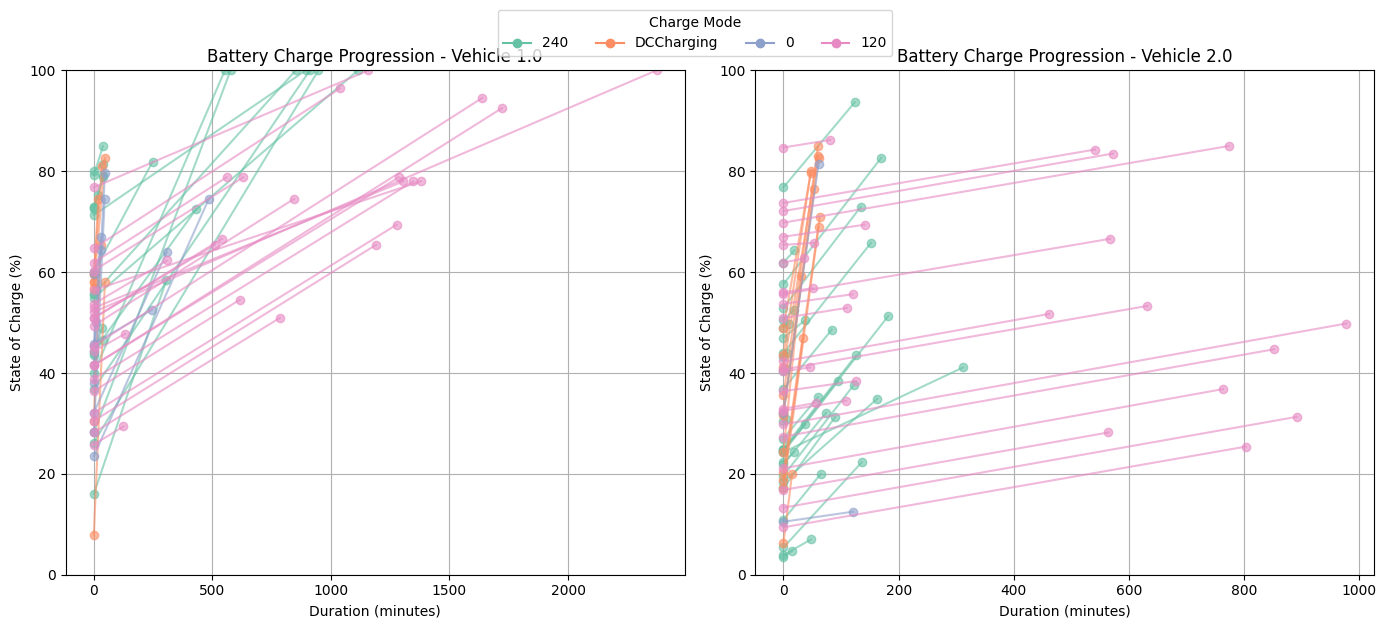

In [269]:
from matplotlib.lines import Line2D
vehicles = charge_data['vin'].dropna().unique()[:2]
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
charge_modes = charge_data['charge_mode'].dropna().unique()
palette = sns.color_palette('Set2', len(charge_modes))
mode_to_color = {mode: palette[i] for i, mode in enumerate(charge_modes)}

for idx, vin in enumerate(vehicles):
    ax = axes[idx]
    subset = charge_data[charge_data['vin'] == vin]

    for mode in charge_modes:
        mode_subset = subset[subset['charge_mode'] == mode]
        for _, row in mode_subset.iterrows():
            x_vals = [0, row['duration']]
            y_vals = [row['soc'], row['end_soc']]
            ax.plot(x_vals, y_vals, marker='o', alpha=0.6, color=mode_to_color[mode])

    ax.set_title(f'Battery Charge Progression - Vehicle {vin}')
    ax.set_xlabel('Duration (minutes)')
    ax.set_ylabel('State of Charge (%)')
    ax.set_ylim(0, 100)
    ax.grid(True)


handles = [Line2D([0], [0], color=mode_to_color[mode], label=mode, marker='o', linestyle='-') for mode in charge_modes]
fig.legend(handles=handles, title='Charge Mode', loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(charge_modes))

plt.tight_layout()
plt.show()

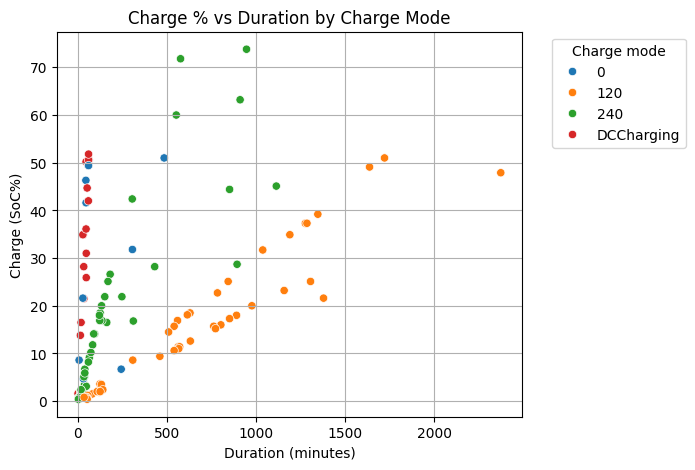

In [270]:
plt.figure(figsize=(6, 5))
sns.scatterplot(data=charge_data, x='duration', y='diff_battery',hue = 'charge_mode', palette = 'tab10')
plt.title('Charge % vs Duration by Charge Mode')
plt.legend(title='Charge mode', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Duration (minutes)')
plt.ylabel('Charge (SoC%)')
plt.grid(True)
plt.show()

#### Charge_mode imputation

##### Angular Coefficient

In [271]:
#print the medium angular coefficient (end_soc - soc) / duration for each charge mode for each vehicle

avg_coeffs = charge_data.groupby(['vin', 'charge_mode'])['perc_per_min'].mean().reset_index()
print("\nAverage angular coefficient (end_soc - soc) / duration for each charge mode for each vehicle:")
print(avg_coeffs)



Average angular coefficient (end_soc - soc) / duration for each charge mode for each vehicle:
   vin charge_mode  perc_per_min
0  1.0           0      0.511816
1  1.0         120      0.027142
2  1.0         240      0.095631
3  1.0  DCCharging      0.848971
4  2.0           0      0.413182
5  2.0         120      0.018621
6  2.0         240      0.120734
7  2.0  DCCharging      0.830703


/var/folders/yf/3whxpy_91xb0fnz553qstm580000gn/T/ipykernel_5884/1042236774.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



##### Clustering

In [272]:
#https://arxiv.org/abs/1907.09458
from sklearn.preprocessing import StandardScaler
features = ['perc_per_min', 'duration', 'diff_battery']
scaler = StandardScaler()
X = scaler.fit_transform(charge_data[features].dropna())
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X)
charge_data.loc[~charge_data[features].isna().any(axis=1), 'cluster'] = labels
mapping = {0: '120', 2: '240', 1: 'DCCharging'}  # esempio
charge_data['charge_mode_inferred'] = charge_data['cluster'].map(mapping)
#change only in charge_mode==0 with the inferred charge_mode
charge_data_inf =charge_data.copy()
charge_data_inf.loc[charge_data_inf['charge_mode'] == '0', 'charge_mode'] = charge_data_inf['charge_mode_inferred']


In [273]:

charge_data = charge_data.reset_index() 

fig = px.scatter(
    charge_data_inf,
    x='duration',
    y='diff_battery',
    color='charge_mode',
    hover_data=[ 'vin', 'cluster'], 
    title='Difference in battery vs duration of charge by each Vehicle Model (Original)',
    labels={
        'cluster': 'cluster_assignment',
        'discharge': 'Discharge (SoC%)',
        'duration': 'Duration (minutes)',
        'vin': 'Vehicle ID'
    }
)

fig.update_layout(
    legend_title_text='Vehicle ID',
    margin=dict(l=20, r=20, t=60, b=20),
    hovermode='closest'
)

fig.show()

In [274]:


charge_data_inf = charge_data_inf.reset_index() 

fig = px.scatter(
    charge_data_inf,
    x='duration',
    y='diff_battery',
    color='charge_mode',
    hover_data=['index', 'vin', 'cluster'], 
    title='Difference in battery vs duration of charge by each Vehicle Model (Clustered only 0 mode)',
    labels={
        'cluster': 'cluster_assignment',
        'discharge': 'Discharge (SoC%)',
        'duration': 'Duration (minutes)',
        'vin': 'Vehicle ID'
    }
)

fig.update_layout(
    legend_title_text='Vehicle ID',
    margin=dict(l=20, r=20, t=60, b=20),
    hovermode='closest'
)

fig.show()


In [275]:
charge_data_inf = charge_data_inf.reset_index() 

fig = px.scatter(
    charge_data_inf,
    x='duration',
    y='diff_battery',
    color='charge_mode_inferred',
    hover_data=['index', 'vin', 'cluster'], 
    title='Difference in battery vs duration of charge by each Vehicle Model (Clustered all charge modes)',
    labels={
        'cluster': 'cluster_assignment',
        'discharge': 'Discharge (SoC%)',
        'duration': 'Duration (minutes)',
        'vin': 'Vehicle ID'
    }
)

fig.update_layout(
    legend_title_text='Vehicle ID',
    margin=dict(l=20, r=20, t=60, b=20),
    hovermode='closest'
)

fig.show()

## Event timeline

In [276]:
data['event_id'] = range(1, len(data) + 1)
first_data = data['timestamp'].min() 
last_data = data['end_time'].max()

In [277]:
def event_label(row):
    if row['event'] == 'trip':
        return 'trip'
    elif row['event'] == 'charge' and str(row['charge_mode']) == '240':
        return 'charge_240'
    elif row['event'] == 'charge' and str(row['charge_mode']) == 'DCCharging':
        return 'charge_DC'
    elif row['event'] == 'charge' and str(row['charge_mode']) == '120':
        return 'charge_120'
    else:
        return 'ignore'
color_map = {
    'trip': "#ff0000",
    'charge_240': "#b2fc62",
    'charge_DC': "#004af7",
    'charge_120': "#9400f7"
}


legend_labels = {
    'trip': 'Trip',
    'charge_240': 'Charge (240V)',
    'charge_DC': 'Charge (DC)',
    'charge_120': 'Charge (120V)'
}


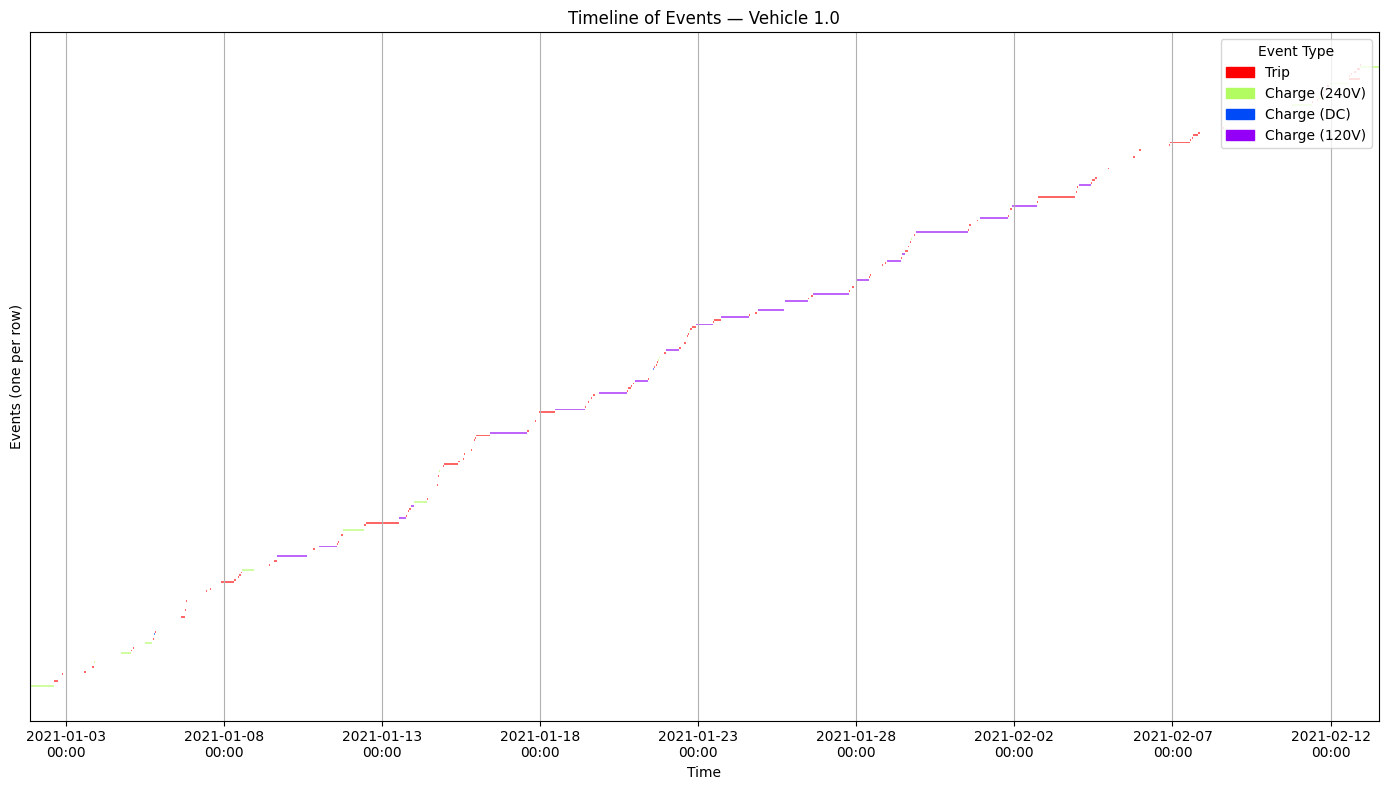

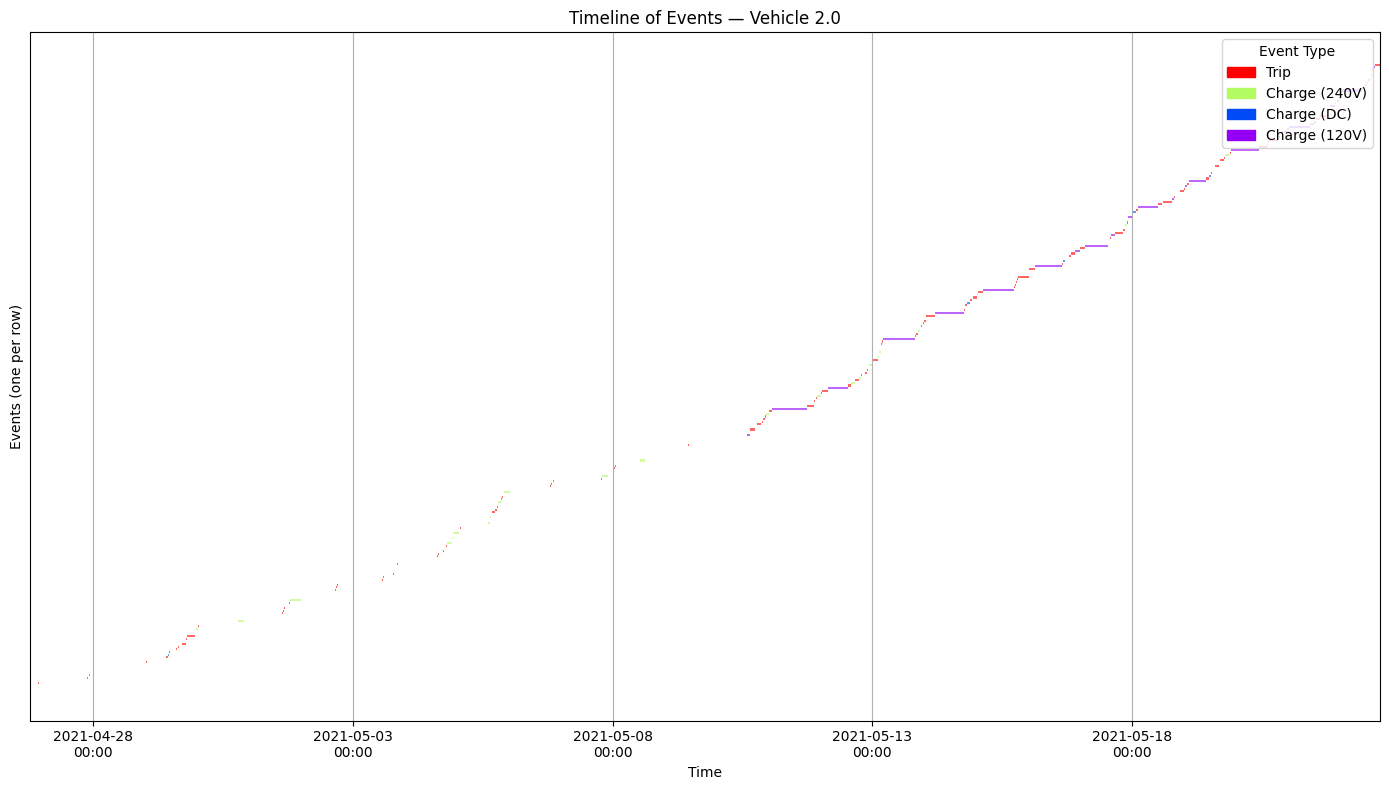

In [278]:
vehicles = data['vin'].dropna().unique()

for vin in vehicles:
    fig, ax = plt.subplots(figsize=(14, 8))
    subset = data[data['vin'] == vin].sort_values(by='timestamp').reset_index(drop=True)

    # Calcola il range temporale solo per questo veicolo
    first_data_local = subset['timestamp'].min()
    last_data_local = subset['end_time'].max()

    y_offset = 0
    bar_height = 8

    for _, row in subset.iterrows():
        event_type = event_label(row)
        if event_type == 'ignore':
            continue  

        start = mdates.date2num(row['timestamp'])
        end = mdates.date2num(row['end_time'])
        duration = end - start
        color = color_map.get(event_type, 'gray')

        ax.broken_barh(
            [(start, duration)],
            (y_offset, bar_height),
            facecolors=color,
            alpha=0.6
        )
        y_offset += bar_height + 2

    # Limita l’asse X al solo intervallo di tempo del veicolo
    ax.set_xlim(mdates.date2num(first_data_local), mdates.date2num(last_data_local))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M'))
    ax.set_xlabel('Time')
    ax.set_ylabel('Events (one per row)')
    ax.set_title(f'Timeline of Events — Vehicle {vin}')
    ax.grid(True)
    ax.set_yticks([])

    legend_patches = [mpatches.Patch(color=color_map[k], label=v) for k, v in legend_labels.items()]
    ax.legend(handles=legend_patches, title='Event Type', loc='upper right')

    plt.tight_layout()
    plt.show()

In [279]:
import plotly.graph_objects as go
import pandas as pd

data['timestamp'] = pd.to_datetime(data['timestamp'])
data['end_time'] = pd.to_datetime(data['end_time'])
data['event_id'] = range(1, len(data) + 1)





vehicles = data['vin'].dropna().unique()
for vin in vehicles:
    subset = data[data['vin'] == vin].sort_values(by='timestamp').reset_index(drop=True)

    fig = go.Figure()

    for i, row in subset.iterrows():
        event_type = event_label(row)
        if event_type == 'ignore':
            continue


        fig.add_trace(go.Scatter(
            x=[row['timestamp'], row['end_time']],
            y=[i, i],
            mode='lines+markers',
            line=dict(color=color_map[event_type], width=10),
            marker=dict(color=color_map[event_type], size=12),
            name=legend_labels[event_type],
            hovertemplate=f"ID: {row['event_id']}<br>Type: {legend_labels[event_type]}<br>Start: {row['timestamp']}<br>End: {row['end_time']}<extra></extra>",
            showlegend=not any(t.name == legend_labels[event_type] for t in fig.data)
        ))

    fig.update_layout(
        title=f"Interactive Timeline of Events — Vehicle {vin}",
        xaxis_title="Time",
        yaxis_title="Event Index",
        yaxis=dict(autorange="reversed", tickmode='linear'),
        height=600,
        legend_title="Event Type",
        xaxis=dict(
            type='date',
            tickformatstops=[
                dict(dtickrange=[None, 1000 * 60 * 60 * 24], value="%H:%M"),
                dict(dtickrange=[1000 * 60 * 60 * 24, 1000 * 60 * 60 * 24 * 7], value="%d %b"),
                dict(dtickrange=[1000 * 60 * 60 * 24 * 7, None], value="%b %Y")
            ]
        )
    )

    fig.show()

### Analysis of Overlapping Events

In [280]:

overlapping_events = []
for vm, group in data.sort_values(by='timestamp').groupby('vin'):
    group = group.sort_values(by='timestamp').reset_index(drop=True)
    
    for i in range(1, len(group)):
        prev_end = group.loc[i - 1, 'end_time']
        curr_start = group.loc[i, 'timestamp']
        
        if pd.notna(prev_end) and pd.notna(curr_start) and curr_start < prev_end:
            overlapping_events.append({
                'vehicle': vm,
                'prev_event_id': group.loc[i - 1, 'event_id'],
                'curr_event_id': group.loc[i, 'event_id'],
                'prev_end': prev_end,
                'curr_start': curr_start
            })


overlap_df = pd.DataFrame(overlapping_events)
print(f"🔍 Found {len(overlap_df)} overlapping event pairs.\n")
print(overlap_df)

🔍 Found 3 overlapping event pairs.

   vehicle  prev_event_id  curr_event_id            prev_end  \
0      1.0            420            426 2021-02-12 14:16:00   
1      1.0            427            421 2021-02-12 22:27:00   
2      1.0            425            428 2021-02-13 12:32:00   

           curr_start  
0 2021-02-12 13:52:00  
1 2021-02-12 14:16:00  
2 2021-02-12 22:27:00  


In [281]:
data.to_csv('./Dataset_dumarey/preprocessed_dataset/dataset_preprocessed.csv', index=False)

# OneHotEncoder

In [282]:
ohe = OneHotEncoder(handle_unknown='ignore')
# Fit the one-hot encoder on training data
cols_to_convert = ['event', 'charge_mode']
ohe.fit(data[cols_to_convert])
# Create a new DataFrame with only the one-hot encoded columns
temp_data = pd.DataFrame(data=ohe.transform(data[cols_to_convert]).toarray(),
                             columns=ohe.get_feature_names_out())
# Create a copy of the DataFrame
data_encoded = data.copy()

# Remove the old categorical columns from the original data
data_encoded.drop(columns=cols_to_convert, axis=1, inplace=True)
data_encoded = pd.concat([data_encoded.reset_index(drop=True), temp_data], axis=1)


In [283]:
data_encoded.drop(columns=['charge_mode_0'], axis=1, inplace=True)
data_encoded.head()

vin           timestamp            end_time          odo     end_odo  \
0  1.0 2021-01-01 20:31:00 2021-01-01 20:38:00  4436.640625  4439.46875   
1  1.0 2021-01-01 20:39:00 2021-01-02 15:13:00  4439.468750  4439.46875   
2  1.0 2021-01-02 15:13:00 2021-01-02 15:21:00  4439.468750  4442.50000   
3  1.0 2021-01-02 15:21:00 2021-01-02 17:46:00  4442.500000  4457.12500   
4  1.0 2021-01-02 17:46:00 2021-01-02 17:53:00  4457.125000  4461.45000   

     soc  end_soc  duration  avg_speed  event_id  event_ trip  event_charge  \
0   56.4     54.9       7.0  24.241071         1          0.0           0.0   
1   54.9    100.0    1114.0   0.000000         2          0.0           1.0   
2  100.0    100.0       8.0  22.734375         3          0.0           0.0   
3  100.0     94.5     145.0   6.051724         4          0.0           0.0   
4   94.5     94.5       7.0  37.071429         5          0.0           0.0   

   event_trip  charge_mode_120  charge_mode_240  charge_mode_DCCharging  
0         1.0              0.0              0.0                     0.0  
1         0.0              0.0              1.0                     0.0  
2         1.0              0.0              0.0                     0.0  
3         1.0              0.0              0.0                     0.0  
4         1.0              0.0              0.0                     0.0

In [284]:
#selecting numerical columns
cols_to_exclude = ['vin', 'event_id']
numerical_cols = data_encoded.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in cols_to_exclude]


# Selecting only numerical columns for correlation
numerical_data = data_encoded[numerical_cols]
vehicles = data_encoded['vin'].unique()


### Feature Correlation Heatmap

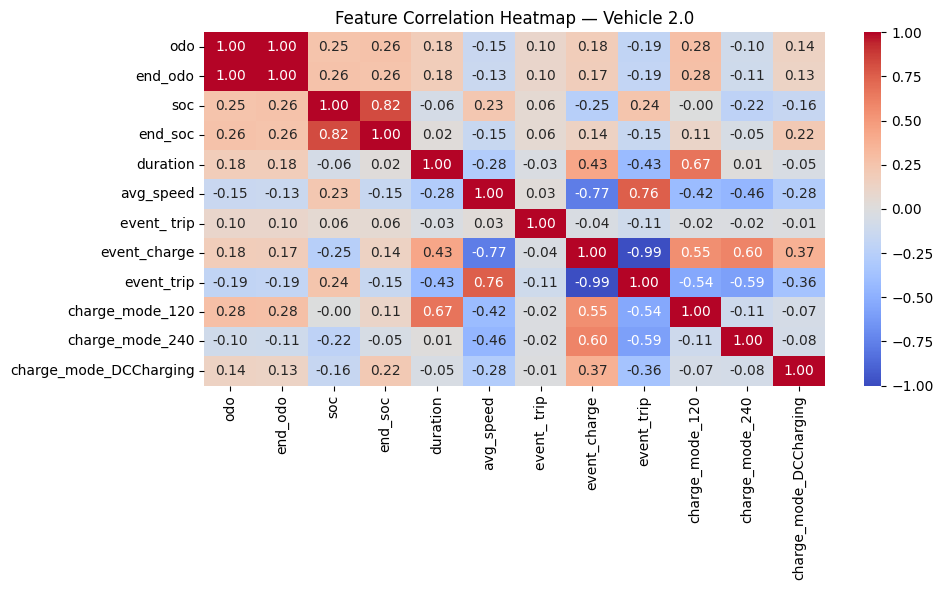

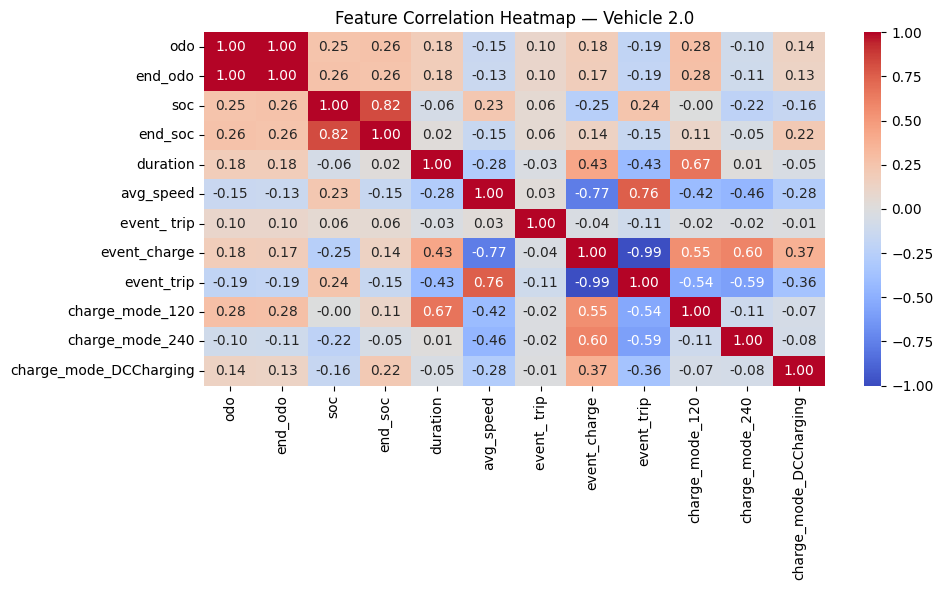

In [285]:
for vehicle in vehicles:
    subset = data_encoded[data_encoded['vin'] == vin]

    numerical_data = subset[numerical_cols]

    if numerical_data.shape[0] < 2:
        continue 

    corr = numerical_data.corr()

    plt.figure(figsize=(10, 6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
    plt.title(f'Feature Correlation Heatmap — Vehicle {vin}')
    plt.tight_layout()
    plt.show()

In [286]:
data_encoded.to_csv('./Dataset_dumarey/preprocessed_dataset/dataset_OHE.csv', index=False)

# 2D Embedding

In [287]:
data_embedded = data.copy()

In [288]:
data_embedded.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   vin          518 non-null    float64       
 1   timestamp    518 non-null    datetime64[ns]
 2   end_time     518 non-null    datetime64[ns]
 3   odo          518 non-null    float64       
 4   end_odo      518 non-null    float64       
 5   soc          518 non-null    float64       
 6   end_soc      518 non-null    float64       
 7   event        518 non-null    category      
 8   charge_mode  518 non-null    category      
 9   duration     518 non-null    float64       
 10  avg_speed    518 non-null    float64       
 11  event_id     518 non-null    int64         
dtypes: category(2), datetime64[ns](2), float64(7), int64(1)
memory usage: 41.9 KB


In [289]:
data_embedded.head()

vin           timestamp            end_time          odo     end_odo  \
0  1.0 2021-01-01 20:31:00 2021-01-01 20:38:00  4436.640625  4439.46875   
1  1.0 2021-01-01 20:39:00 2021-01-02 15:13:00  4439.468750  4439.46875   
2  1.0 2021-01-02 15:13:00 2021-01-02 15:21:00  4439.468750  4442.50000   
3  1.0 2021-01-02 15:21:00 2021-01-02 17:46:00  4442.500000  4457.12500   
4  1.0 2021-01-02 17:46:00 2021-01-02 17:53:00  4457.125000  4461.45000   

     soc  end_soc   event charge_mode  duration  avg_speed  event_id  
0   56.4     54.9    trip           0       7.0  24.241071         1  
1   54.9    100.0  charge         240    1114.0   0.000000         2  
2  100.0    100.0    trip           0       8.0  22.734375         3  
3  100.0     94.5    trip           0     145.0   6.051724         4  
4   94.5     94.5    trip           0       7.0  37.071429         5

In [290]:
# === EMBEDDING PREPARATION ===
import torch
label_encoders = {}
cat_indices = {}
for col in cols_to_convert:
    le = LabelEncoder()
    cat_indices[col + "_idx"] = le.fit_transform(data_embedded[col].astype(str))
    label_encoders[col] = le

data_cat_idx = pd.DataFrame(cat_indices)
X_cat = torch.tensor(data_cat_idx.values, dtype=torch.long)

num_classes_per_cat = [len(label_encoders[col].classes_) for col in cols_to_convert]
embedding_dims = [2 for _ in num_classes_per_cat] 

embedding_layers = nn.ModuleList([
    nn.Embedding(num_embeddings=n, embedding_dim=d)
    for n, d in zip(num_classes_per_cat, embedding_dims)
])


embedded_parts = [embedding_layers[i](X_cat[:, i]) for i in range(X_cat.shape[1])]
embedded_features = torch.cat(embedded_parts, dim=1)  # [num_samples, total_emb_dim]

embedded_feature_names = []
for col, dim in zip(cols_to_convert, embedding_dims):
    embedded_feature_names.extend([f"{col}_emb_{i}" for i in range(dim)])

df_embedded = pd.DataFrame(embedded_features.detach().numpy(), columns=embedded_feature_names)



data_noncat = data_embedded.drop(columns=cols_to_convert).reset_index(drop=True)

data_embedded = pd.concat([data_noncat, df_embedded], axis=1)

In [291]:
data_embedded.head()

vin           timestamp            end_time          odo     end_odo  \
0  1.0 2021-01-01 20:31:00 2021-01-01 20:38:00  4436.640625  4439.46875   
1  1.0 2021-01-01 20:39:00 2021-01-02 15:13:00  4439.468750  4439.46875   
2  1.0 2021-01-02 15:13:00 2021-01-02 15:21:00  4439.468750  4442.50000   
3  1.0 2021-01-02 15:21:00 2021-01-02 17:46:00  4442.500000  4457.12500   
4  1.0 2021-01-02 17:46:00 2021-01-02 17:53:00  4457.125000  4461.45000   

     soc  end_soc  duration  avg_speed  event_id  event_emb_0  event_emb_1  \
0   56.4     54.9       7.0  24.241071         1    -1.191727     1.848105   
1   54.9    100.0    1114.0   0.000000         2    -0.004944     0.154129   
2  100.0    100.0       8.0  22.734375         3    -1.191727     1.848105   
3  100.0     94.5     145.0   6.051724         4    -1.191727     1.848105   
4   94.5     94.5       7.0  37.071429         5    -1.191727     1.848105   

   charge_mode_emb_0  charge_mode_emb_1  
0          -1.855220           0.051688  
1          -0.961984          -0.528799  
2          -1.855220           0.051688  
3          -1.855220           0.051688  
4          -1.855220           0.051688

In [292]:
cols_to_convert = ['event_emb_0','event_emb_1', 'charge_mode_emb_0', 'charge_mode_emb_1']
data_embedded[cols_to_convert] = data_embedded[cols_to_convert].astype('float64')
data_embedded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   vin                518 non-null    float64       
 1   timestamp          518 non-null    datetime64[ns]
 2   end_time           518 non-null    datetime64[ns]
 3   odo                518 non-null    float64       
 4   end_odo            518 non-null    float64       
 5   soc                518 non-null    float64       
 6   end_soc            518 non-null    float64       
 7   duration           518 non-null    float64       
 8   avg_speed          518 non-null    float64       
 9   event_id           518 non-null    int64         
 10  event_emb_0        518 non-null    float64       
 11  event_emb_1        518 non-null    float64       
 12  charge_mode_emb_0  518 non-null    float64       
 13  charge_mode_emb_1  518 non-null    float64       
dtypes: datetim

In [293]:
data_embedded.to_csv('./Dataset_dumarey/preprocessed_dataset/dataset_2DE.csv', index=False)

### Timestamp Normalization to Hours Since Start

In [294]:
#select the least recent date in timestamp
min_date = data_embedded['timestamp'].min()
#compute the difference in hour from the minimum date
data_embedded['timestamp'] = (data_embedded['timestamp'] - min_date).dt.total_seconds() / 3600
data_embedded['end_time'] = (data_embedded['end_time'] - min_date).dt.total_seconds() / 3600

In [295]:
#selecting numerical columns
cols_to_exclude = ['vin', 'event_id']
numerical_cols = data_embedded.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in cols_to_exclude]

# Selecting only numerical columns for correlation
numerical_data = data_embedded[numerical_cols]
vehicles = data_embedded['vin'].unique()

### Feature Correlation Heatmap

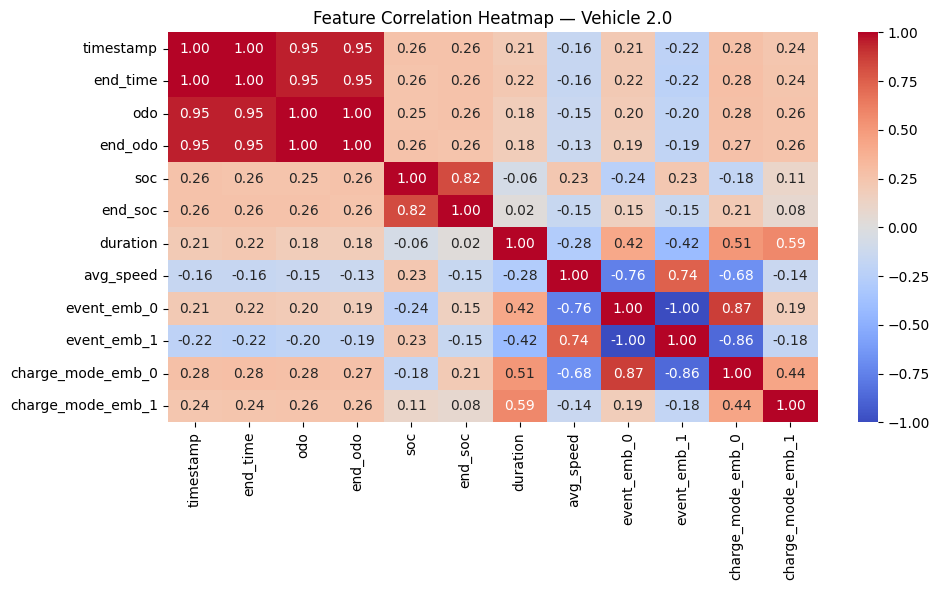

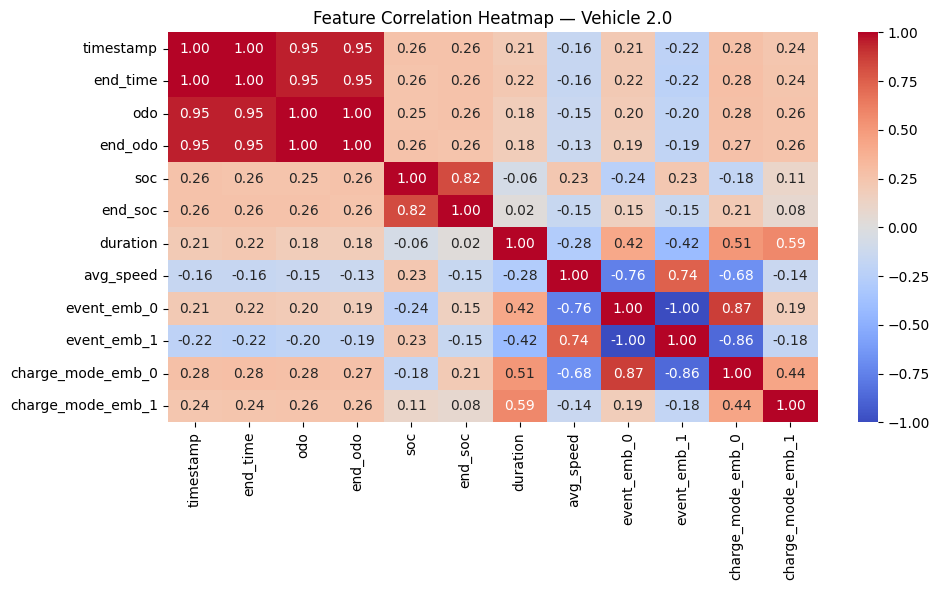

In [296]:
for vehicle in vehicles:
    subset = data_embedded[data_encoded['vin'] == vin]

    numerical_data = subset[numerical_cols]

    if numerical_data.shape[0] < 2:
        continue 

    corr = numerical_data.corr()

    plt.figure(figsize=(10, 6))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
    plt.title(f'Feature Correlation Heatmap — Vehicle {vin}')
    plt.tight_layout()
    plt.show()


In [297]:
data_embedded.to_csv('./Dataset_dumarey/preprocessed_dataset/dataset_2DE_time_norm.csv', index=False)

In [298]:

data_embedded['event'] = label_encoders['event'].inverse_transform(data_cat_idx['event_idx'])
data_embedded['charge_mode'] = label_encoders['charge_mode'].inverse_transform(data_cat_idx['charge_mode_idx'])


data_from_2DE_to_original = data_embedded.drop(columns=[
    'event_emb_0', 'event_emb_1',
    'charge_mode_emb_0', 'charge_mode_emb_1'
])

In [299]:
data_from_2DE_to_original.head()

vin  timestamp   end_time          odo     end_odo    soc  end_soc  \
0  1.0   0.000000   0.116667  4436.640625  4439.46875   56.4     54.9   
1  1.0   0.133333  18.700000  4439.468750  4439.46875   54.9    100.0   
2  1.0  18.700000  18.833333  4439.468750  4442.50000  100.0    100.0   
3  1.0  18.833333  21.250000  4442.500000  4457.12500  100.0     94.5   
4  1.0  21.250000  21.366667  4457.125000  4461.45000   94.5     94.5   

   duration  avg_speed  event_id   event charge_mode  
0       7.0  24.241071         1    trip           0  
1    1114.0   0.000000         2  charge         240  
2       8.0  22.734375         3    trip           0  
3     145.0   6.051724         4    trip           0  
4       7.0  37.071429         5    trip           0

In [300]:
cols_to_convert = ['event', 'charge_mode']
for col in cols_to_convert:
    data_from_2DE_to_original[col] = data_from_2DE_to_original[col].astype('category')
data_from_2DE_to_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   vin          518 non-null    float64 
 1   timestamp    518 non-null    float64 
 2   end_time     518 non-null    float64 
 3   odo          518 non-null    float64 
 4   end_odo      518 non-null    float64 
 5   soc          518 non-null    float64 
 6   end_soc      518 non-null    float64 
 7   duration     518 non-null    float64 
 8   avg_speed    518 non-null    float64 
 9   event_id     518 non-null    int64   
 10  event        518 non-null    category
 11  charge_mode  518 non-null    category
dtypes: category(2), float64(9), int64(1)
memory usage: 41.9 KB
